# Cleaning PSAP raw data

In this script I will collect, clean and organise the raw data files for the new PSAP stationed at Zeppelin. The "New PSAP" as it is known operates using an automatic filter change. Whereby the filter is changed when the tranmission decreases by a certain amount. As the aerosol concentrations are lower in the summer, the samping times/duration the filter is on is greater.

The data is sorted via the separate filters, the filters are then inspected and the "bad filters" are removed. 

Finally, a rolling averge is applied for 3 neigbouring points (set on the middle point). The Bond correction is done with a time step (set at 15 minutes). The absorption coefficent is calculated by loking at the change in the transmission.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
import matplotlib.ticker as ticker
import cmocean

In [2]:
# use the following path to save any plots and files
out_path_plots = "C:\\Users\\DominicHeslinRees\\Pictures\\black_carbon\\new_PSAP\\"
out_path_datafiles = "C:\\Users\\DominicHeslinRees\\Documents\\Data\\processed_data\\new_PSAP\\"

The raw data files for the new PSAP can be imported as follows:

In [3]:
def append_soot_raw(path, years, col_names, name):
    appended_data = []   
    for year in years:      
        print(year)
        list_RAW_PSAP_files = glob.glob(path+str(year)+'\\'+str(name)+' *')
        print('length: '+str(len(list_RAW_PSAP_files)))
        for infile in glob.glob(path+str(year)+'\\'+str(name)+' *'):
            rows_skip = []            
            with open(infile) as f:
                lines = f.readlines()
                for value, line in enumerate(lines):

                    if (len(line) <= 36) or (len(line) >= len(col_names)*11) or (line[0] == 'D') or (line[0] == np.nan):

                        rows_skip.append(value)

            try:
                df = pd.read_csv(infile, sep='\t', header=None, skiprows = rows_skip)
                
                if len(df.columns) == len(col_names):
                
                    df.columns = col_names

                    df["Time"] = df["Time"].astype(float)
                    df["Time"] = df["Time"].apply(lambda x: round(x,3))            
                    df["Time"] = df["Time"].astype(int)            
                    df["Time"] = df["Time"].astype(str)
                    df["Time"] = df.apply(lambda row : ((6-len(str(row['Time'])))*'0'+str(row['Time'])), axis = 1) 

                    df["Date"] = df["Date"].astype(str)            
                    df["DateTime"] = pd.to_datetime(df['Date'] + df['Time'])            
                    df["DateTime"] = pd.to_datetime(df.loc[:,"DateTime"], format='%Y%m%d%H%M%S.%fff')

                    df = df.set_index('DateTime')
                    df = df.drop(['Date','Time'], axis=1)
                    
                else:
                    
                    df = pd.DataFrame(columns=col_names[2:], index=range(1))

            except pd.errors.EmptyDataError:
                
                pass      

            appended_data.append(df)

    RAW_PSAP = pd.concat(appended_data) 
    return RAW_PSAP

## Let's append all the raw files we have

In [4]:
path =  "C:\\Users\\DominicHeslinRees\\Documents\\Data\\PSAP_RAW\\RAW_2006-2014\\"
years = np.arange(2012,2015,1)
col_names = ['Date','Time','Io','I','qobs','Lnr','Qset','InTime','Ia','Ib','FChanged','ChangeF','check1','check2']
name = 'sootrawNYA'

RAW_NEW_PSAP = append_soot_raw(path, years, col_names, name)
RAW_NEW_PSAP.dropna(how='all', inplace=True)
RAW_NEW_PSAP.index = RAW_NEW_PSAP.index - pd.DateOffset(days=1) #have to manually offset by a day
RAW_NEW_PSAP.sort_index(inplace=True)

2012
length: 43
2013
length: 375
2014
length: 323


In [5]:
RAW_NEW_PSAP['Io'].values[RAW_NEW_PSAP['Io'].values < 0] = np.nan #There must be some transmittance 
RAW_NEW_PSAP.dropna(subset=['Io'], inplace=True) 

FChnaged shows in most cases when the filter was changed.

Below we find when this variable changed and then we apply a cummulative summation to that column

In [6]:
RAW_NEW_PSAP['FChanged_diff'] = RAW_NEW_PSAP['FChanged'].diff() 
RAW_NEW_PSAP['Filter_cum_v1'] = (RAW_NEW_PSAP['FChanged_diff'] == 1).cumsum()

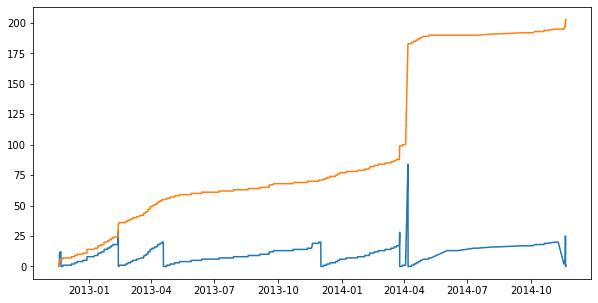

In [7]:
plt.figure(figsize=(10,5))
plt.plot(RAW_NEW_PSAP.index, RAW_NEW_PSAP['FChanged'])
plt.plot(RAW_NEW_PSAP.index, RAW_NEW_PSAP['Filter_cum_v1'])

Fig 1. The cummulative number of filter changes plotted in orange

The data set displays the columns: 'Date', 'Io', 'I', 'qobs', 'Lnr', 'Qset', 'InTime', 'Ia', 'Ib', 'FChanged', 'ChangeF', 'check1', 'check2'. Lnr is used to distinguish the time in which the filter is changed, apart from that it has no genuine significance. 

## Examine the filter change

The raw PSAP data needs to be examined filter by filter, such that each filter is distinguished and separated.  Now, a time difference ($\Delta$t) needs to be selected in order to process the raw data. However, if the $\Delta$t is too large, data will be lost to as the duration each filter lasts may not be strictly divisible by $\Delta$t.

In [8]:
#RAW_NEW_PSAP.to_csv(out_path_datafiles+"raw_new_PSAP.dat",index=True)

Below is a plot showing how the intensity ($I$) monotonically decreases over time, as aerosol particles, in particular light-absorbing aerosols, settles on the filters:

In [9]:
def filter_plot(df, dt_min, dt_max):    
    plt.figure(figsize=(30,8))
    
    df = df[(df.index > dt_min) & (df.index < dt_max)]
    
    plt.plot(df.index, df['ChangeF'], 'o', label='Lnr')    
    plt.plot(df.index, df['I'], 'o', lw=0.5, label='I')
    plt.plot(df.index, df['Io'], 'o', lw=0.5, label='Io')
    
    times_of_filter_changes = df[df['FChanged_diff'] == 1].index
    print(len(times_of_filter_changes))

    for idx in times_of_filter_changes: #mulitple points
        plt.axvline(idx, linewidth=4, color='r', lw=1) #vertical lines distinguishing the filter changes
    
    plt.title(str(dt_min[:4]), fontsize=20)
        
    plt.legend(fontsize=15, loc=7)
    return plt, times_of_filter_changes

The following plots will need to be inspected as there are some breaks and jumps in the filter measurements:

6


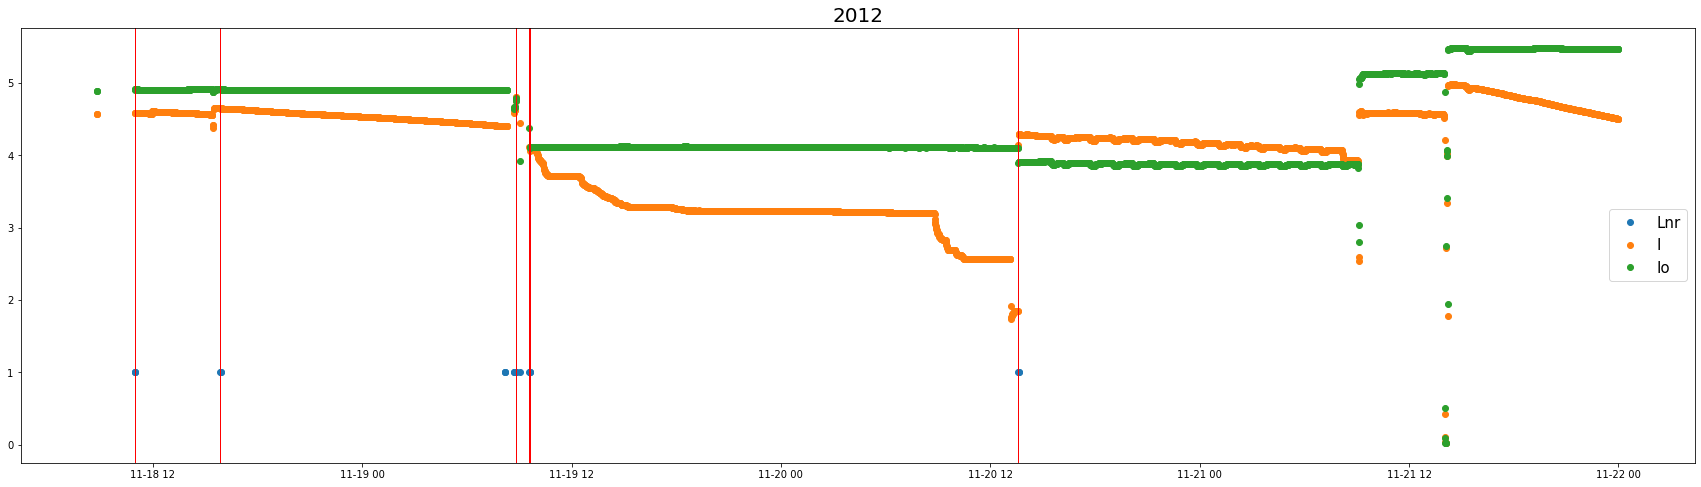

In [10]:
for year in years[:1]:
    filter_plot(RAW_NEW_PSAP, dt_min=str(year)+'-01-01 00:00:00', dt_max=str(year)+'-11-22 00:00:00')

Fig. 2 The lines representing the filter changes are not complete. More need to be added. 

Notice how the length between filters increases during the summer months. This is a result of the Arctic Haze - the increase in the aerosol concentration. 

Additional date times for filter changes need to added. The values during the filter changes also need to be removed.

Let's look at when the transmission (Io) makes large jumps - i.e. when the filters change

In [11]:
RAW_NEW_PSAP['diff'] = RAW_NEW_PSAP['I'].diff().abs()  #abssolute values as we are interested in the size of the jump

In [12]:
def filter_plot(df, dt_min, dt_max, filter_lines):   
    year = pd.to_datetime(dt_min).year
    
    plt.figure(figsize=(30,8))
    
    df = df[(df.index > dt_min) & (df.index < dt_max)]

    
    plt.plot(df.index, df['ChangeF'], 'o', label='Lnr')    
    plt.plot(df.index, df['I'], 'o', lw=0.5, label='I')
    plt.plot(df.index, df['Io'], 'o', lw=0.5, label='Io')
    
    plt.title(str(year)+" Filter lines (blue): "+str(len(filter_lines)),
                              fontsize=20)
        
    for idx in filter_lines:
        if idx.year == year:
            plt.axvline(idx, linewidth=4, color='blue', lw=1)  
            
    plt.xlim(dt_min, dt_max)
        
    plt.legend(fontsize=20, loc=1)
    return plt

Find the extra filter changing times:

In [13]:
#extra_filter_lines + times_of_filter_changes
#extra_filter_idx = RAW_NEW_PSAP[(RAW_NEW_PSAP['diff'] > 0.1) | (RAW_NEW_PSAP['FChanged_diff'] == 1)].index
extra_filter_idx = RAW_NEW_PSAP[(RAW_NEW_PSAP['diff'] > 0.2)].index

We can simplify the filter times as the jumps are more numerous than the actual number of distinct filters. We can do this by finding a datetime index that represents a defined grouping.

In [14]:
def simply_filter_times(filter_times, xmins):
    indexs = []
    within_xmins = (filter_times.to_series().diff().fillna(pd.Timedelta(seconds=0))/np.timedelta64(int(xmins), 'm')).gt(1).cumsum().add(1).astype(int)
    df = within_xmins.to_frame(name="vals")
    for val in df.vals.unique():
        index = df.index[df.vals == val][0]
        indexs.append(index)
    return indexs   

In [15]:
simplified_filter_times = simply_filter_times(extra_filter_idx, xmins=60)
print(len(simplified_filter_times))

98


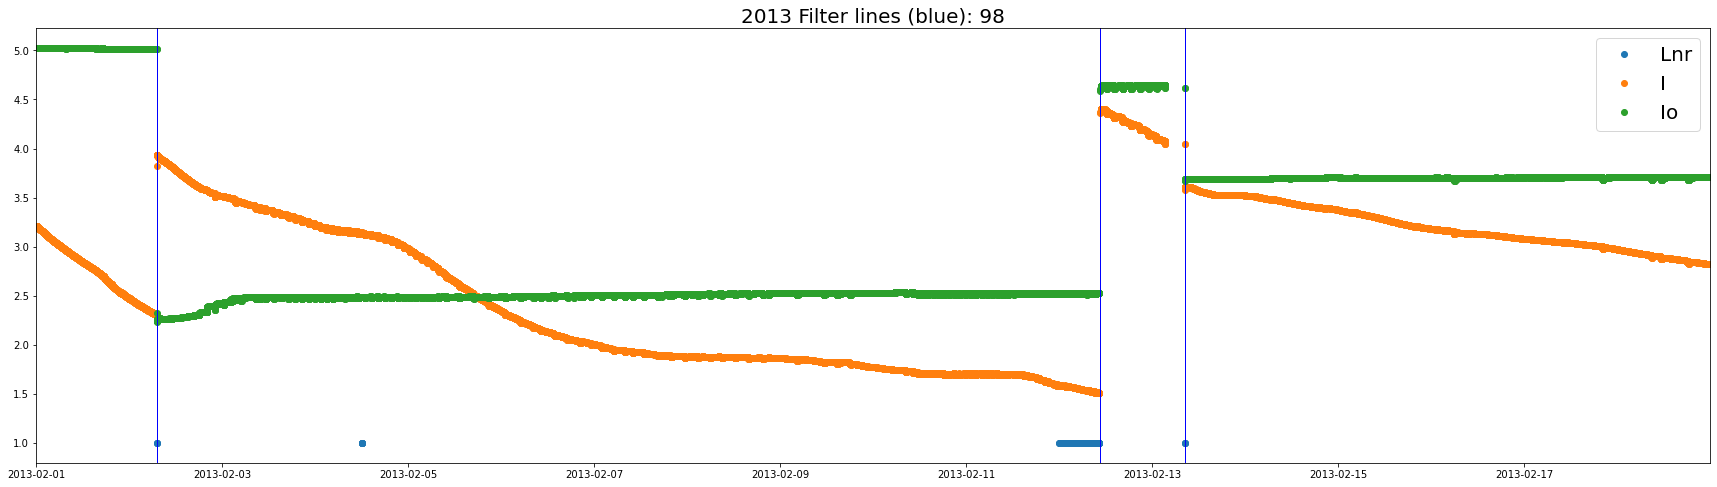

In [16]:
for year in years[1:2]:
    filter_plot(RAW_NEW_PSAP, dt_min=str(year)+'-02-01 00:00:00', dt_max=str(year)+'-02-18 23:59:59', filter_lines=simplified_filter_times)

Fig. 3 example of the filters and the lines representing the change of filter

After the filter changes have been marked using the 'Filter Change' column, a list of dataframes will be created such that each filter has their own dataframe.

In [17]:
RAW_NEW_PSAP['Filter'] = np.nan
RAW_NEW_PSAP.loc[RAW_NEW_PSAP.index.isin(simplified_filter_times), 'Filter'] = 1
RAW_NEW_PSAP['Filter_cum_v2'] = (RAW_NEW_PSAP['Filter'] == 1).cumsum()

Create separate dfs for each filter in order to inspect them:

In [18]:
def create_dfs_for_filters(df):    
    dfs = [x for i, x in df.groupby('Filter_cum_v2') if len(x) > 15]
    return dfs

In [19]:
dfs = create_dfs_for_filters(RAW_NEW_PSAP)
print(len(dfs))

98


In [20]:
def plot_each_filter(df, i):      
    plt.figure(figsize=(20,5))      
    plt.plot(df.index, df['I'], 'o', lw=0.5, label='I')
    plt.plot(df.index, df['Io'], 'o', lw=0.5, label='Io')
    plt.title("Filter: "+str(i), fontsize=20)       
    plt.legend(fontsize=20, loc=2)
    plt.ylim(0, 5.9)
    plt.savefig(out_path_plots+'filters\\'+str(i)+'.jpeg')
    return plt

<ipython-input-20-19b2912e5e1b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,5))


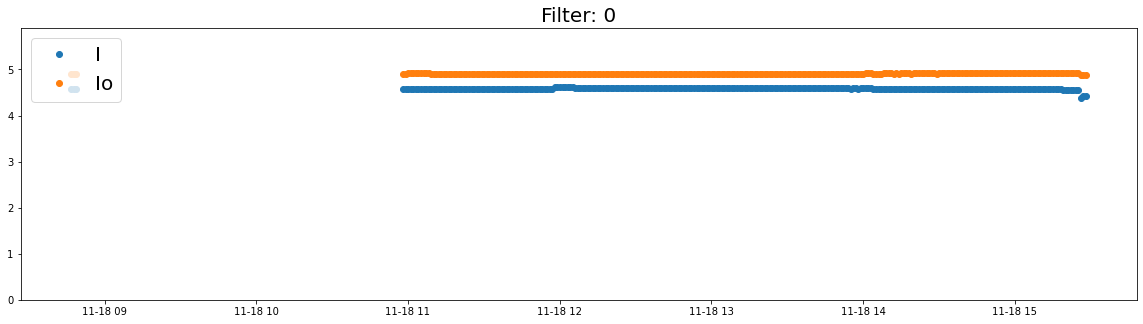

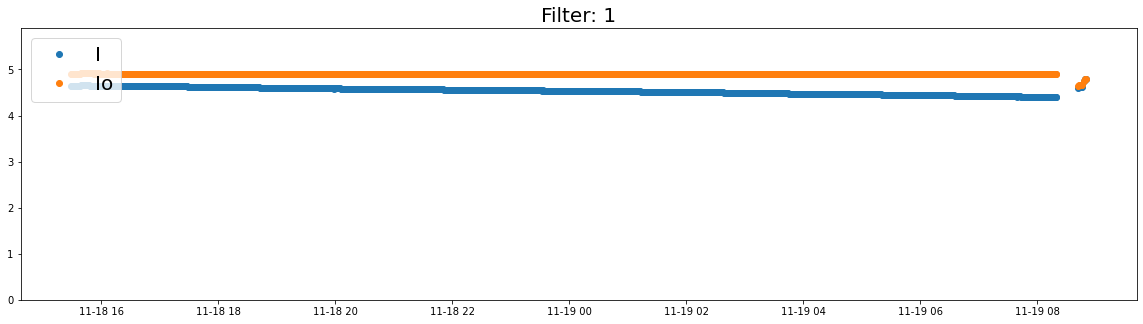

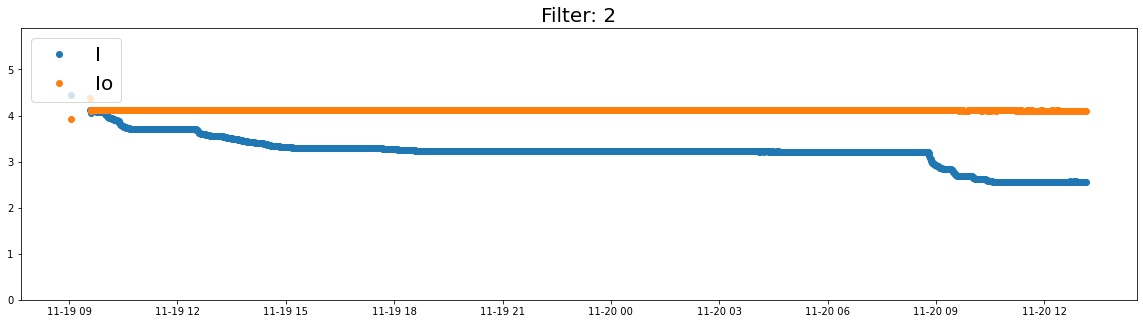

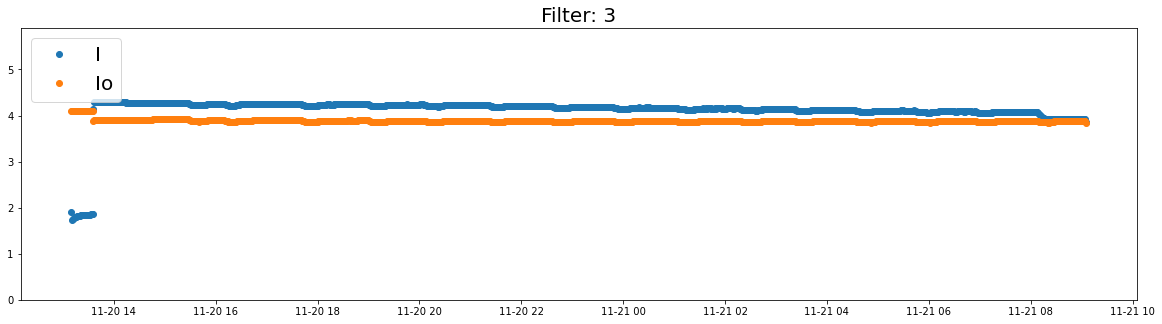

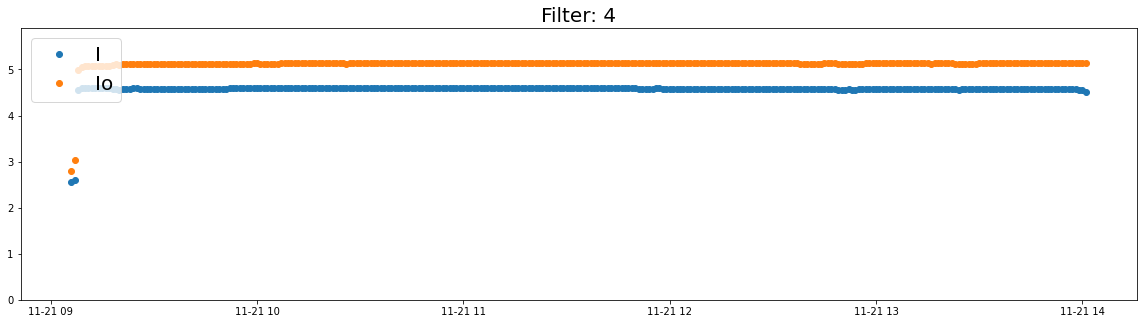

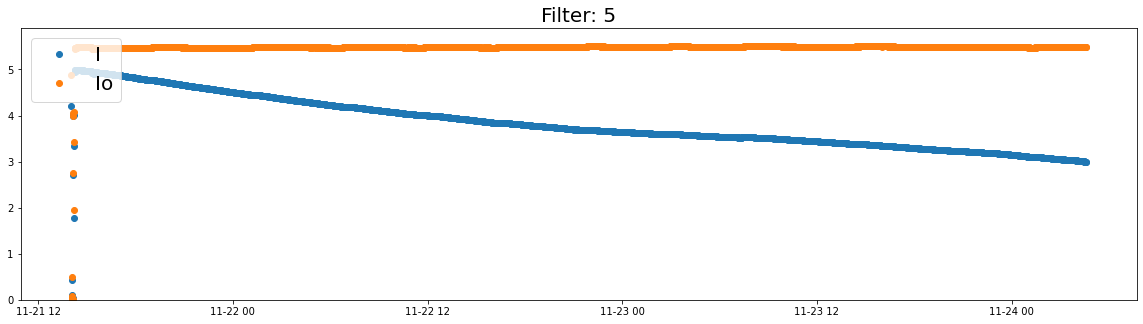

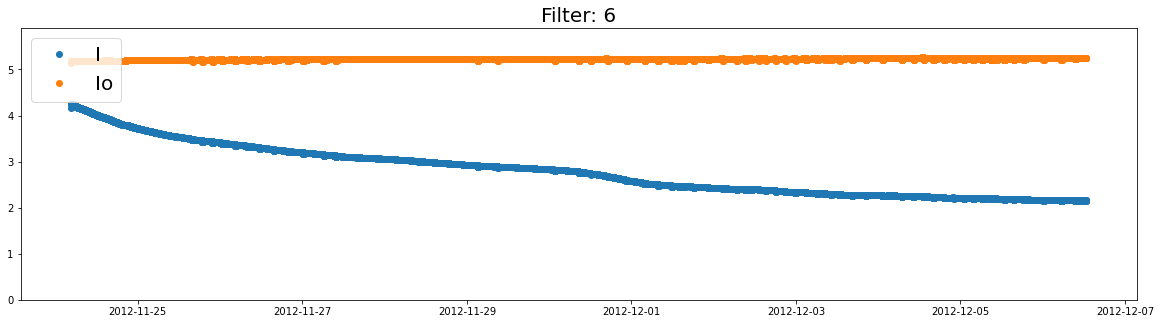

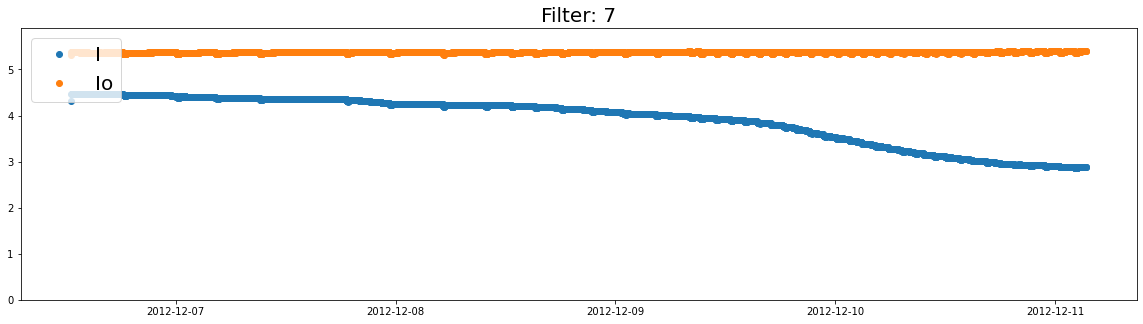

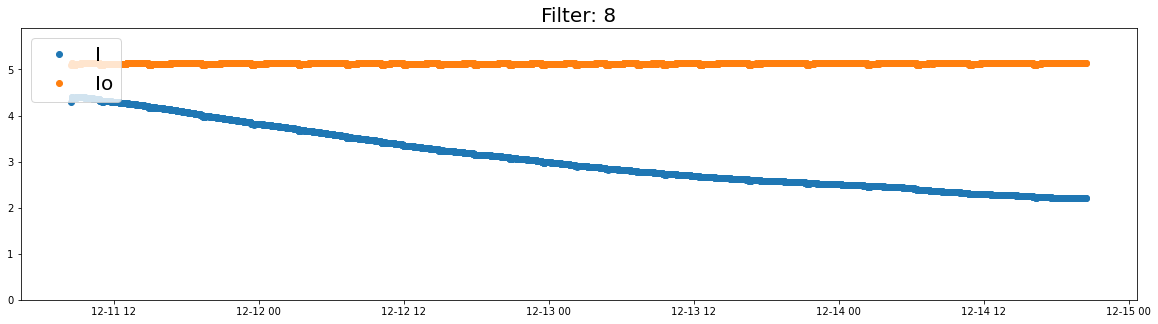

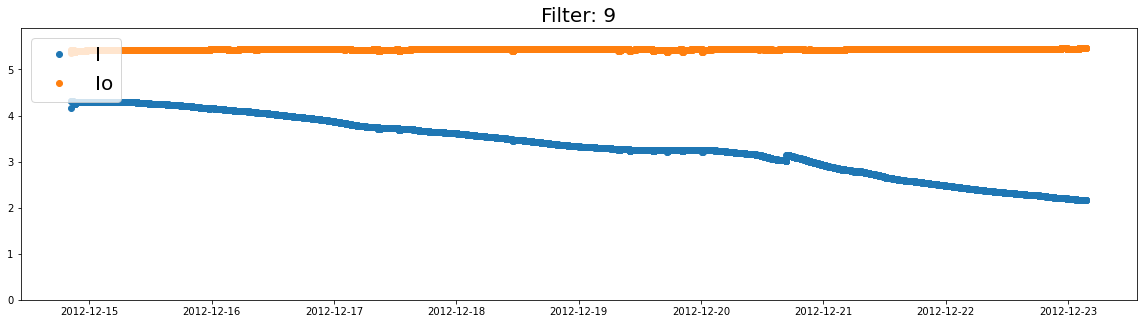

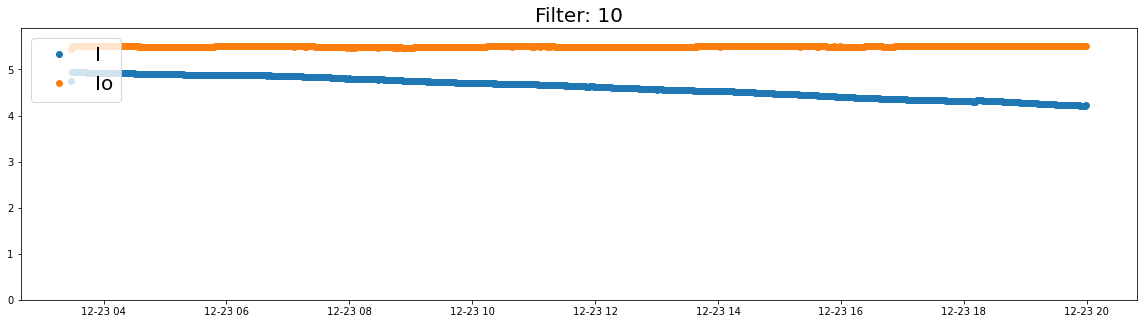

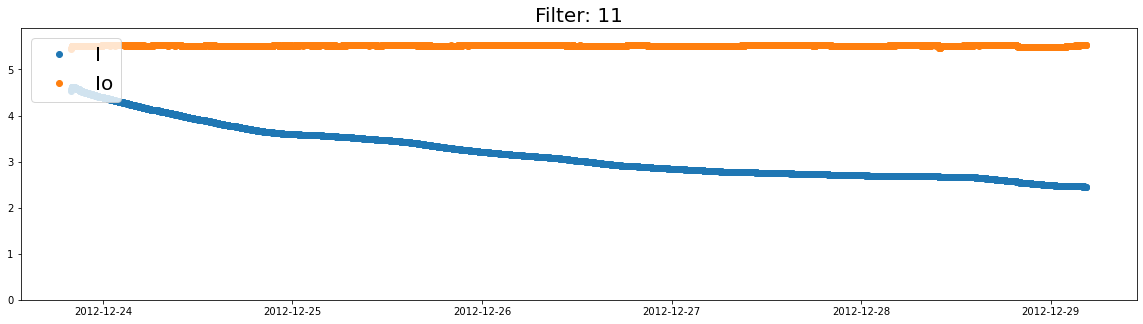

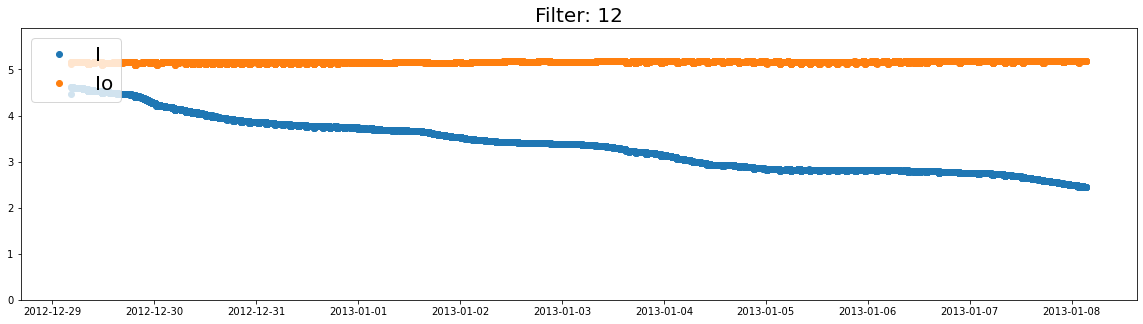

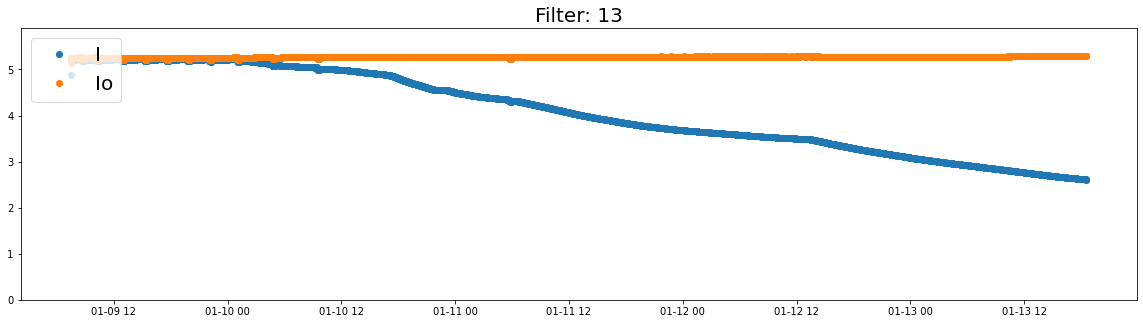

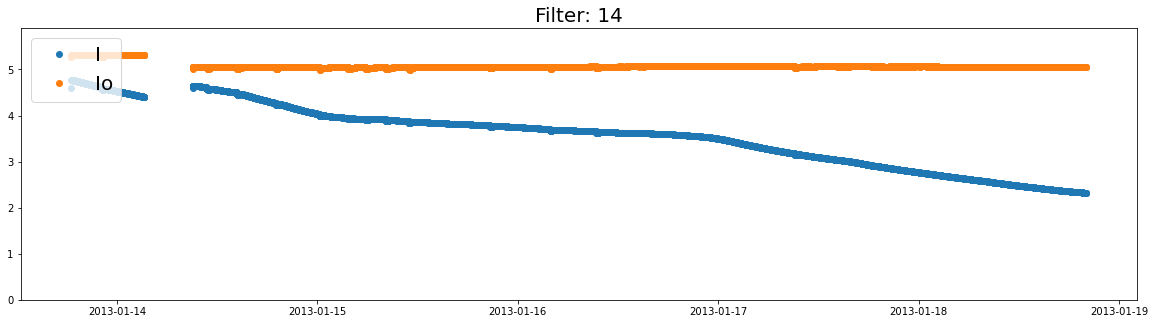

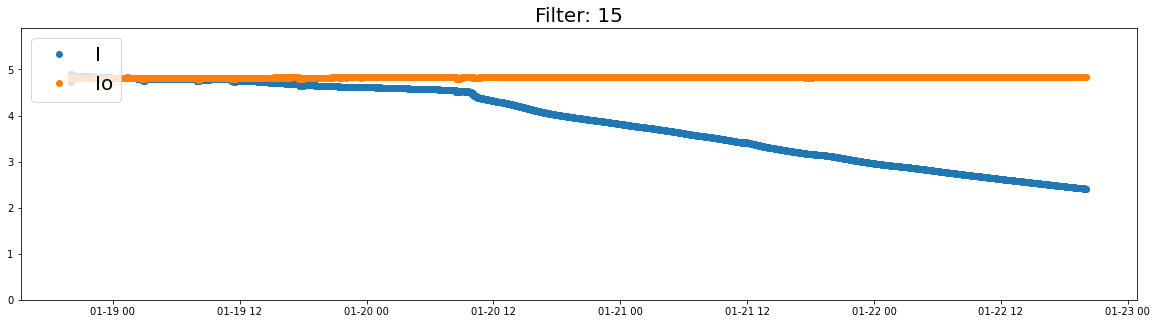

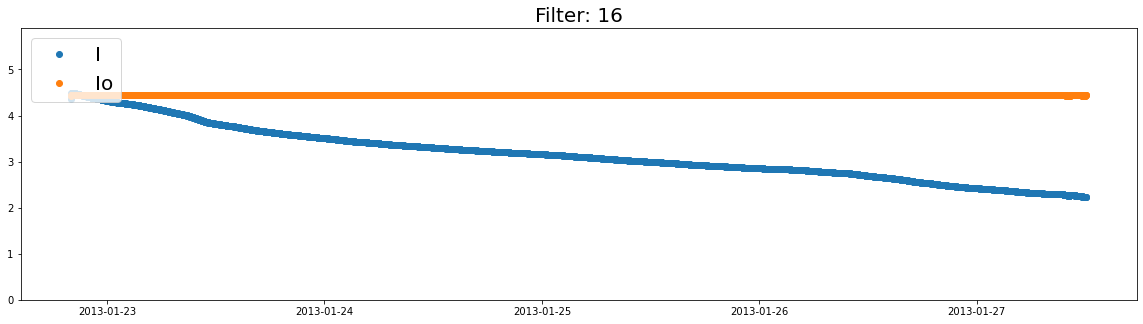

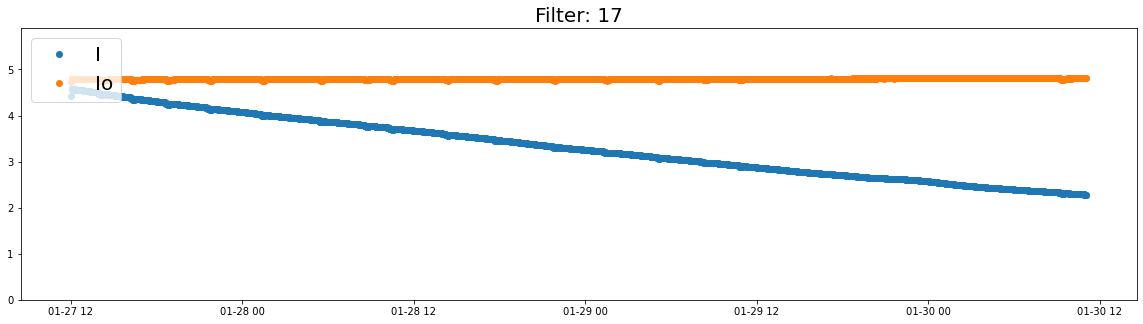

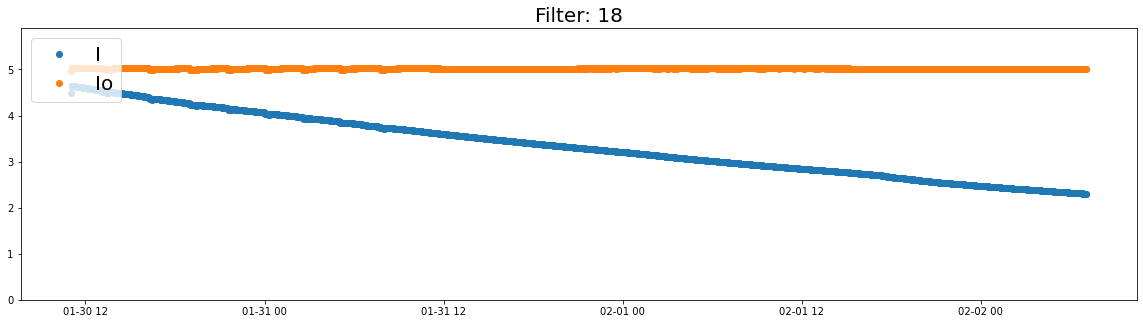

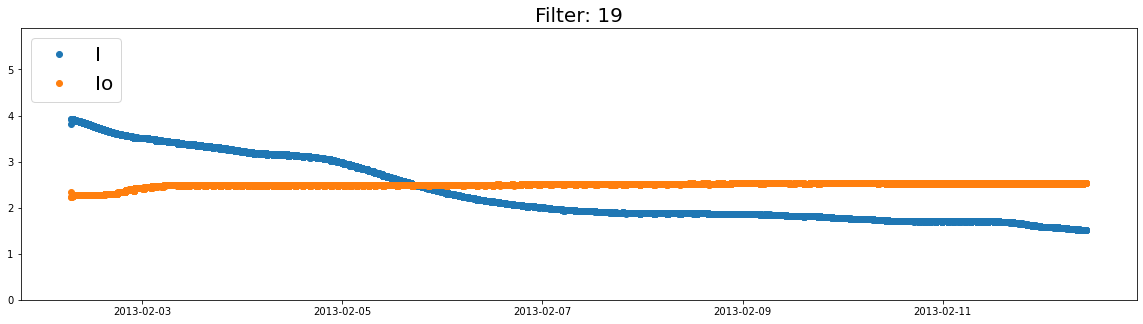

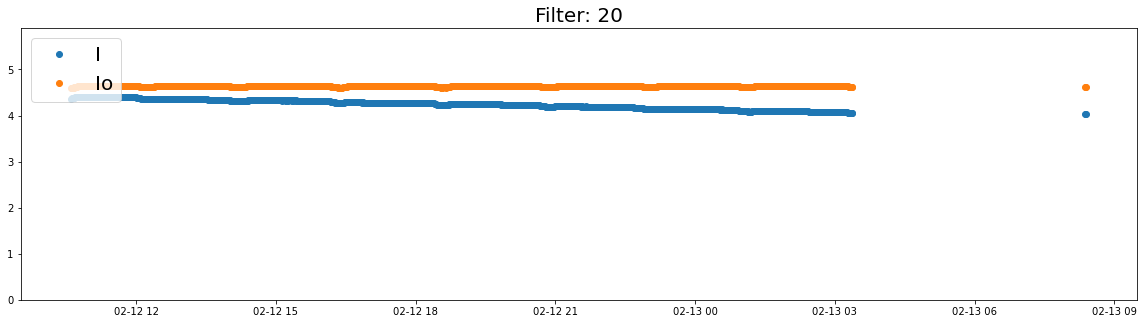

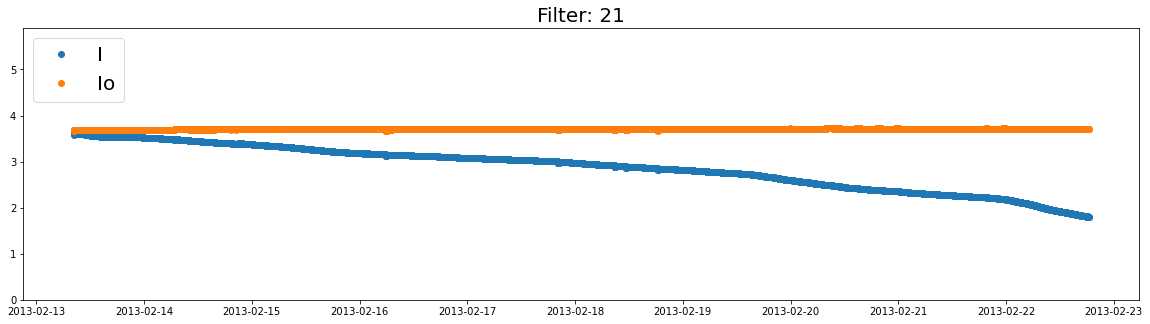

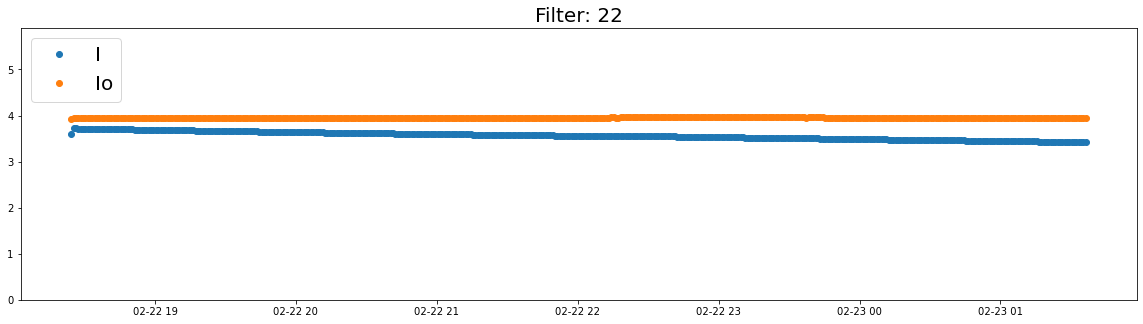

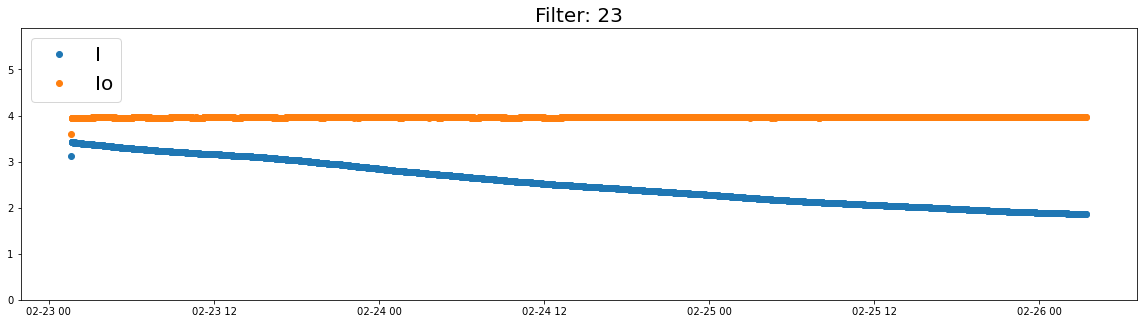

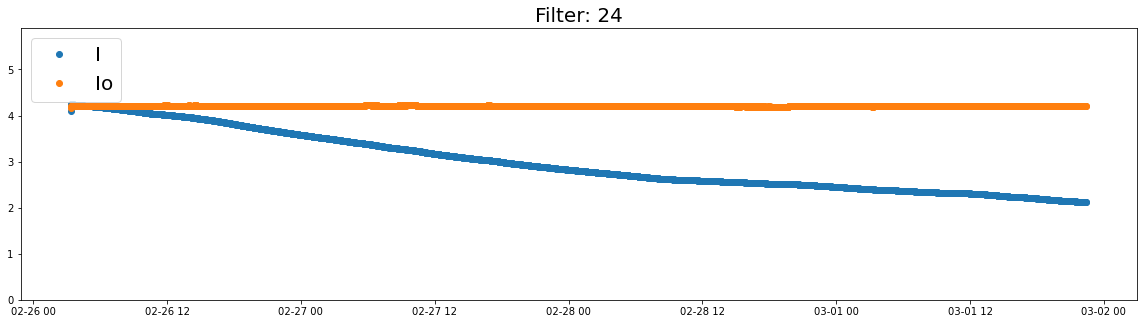

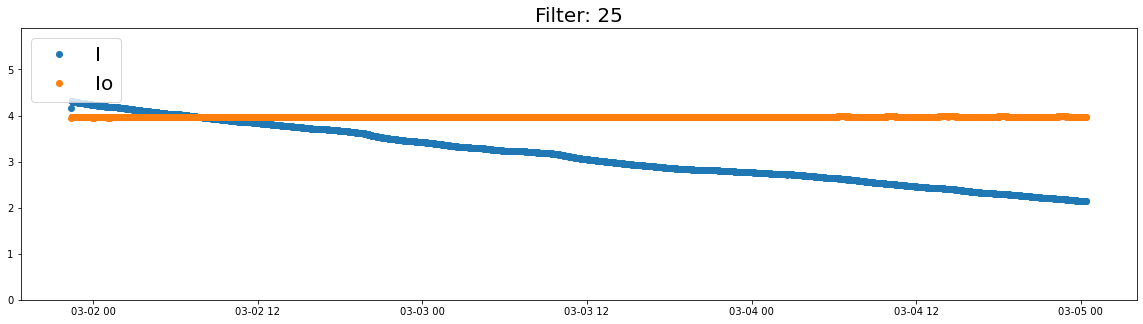

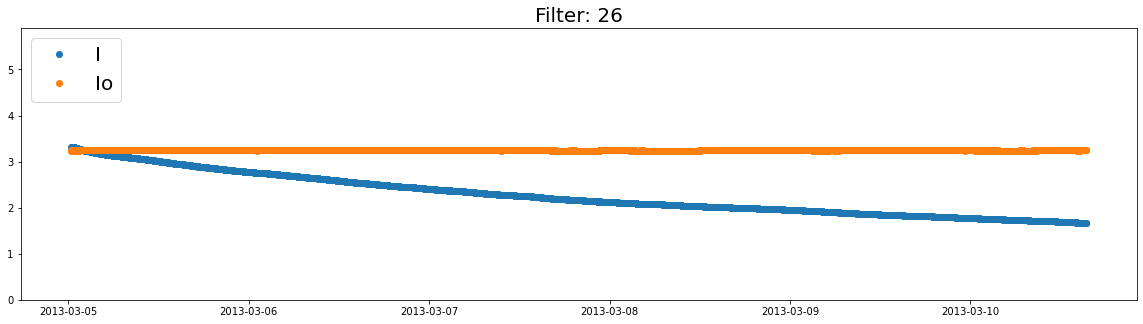

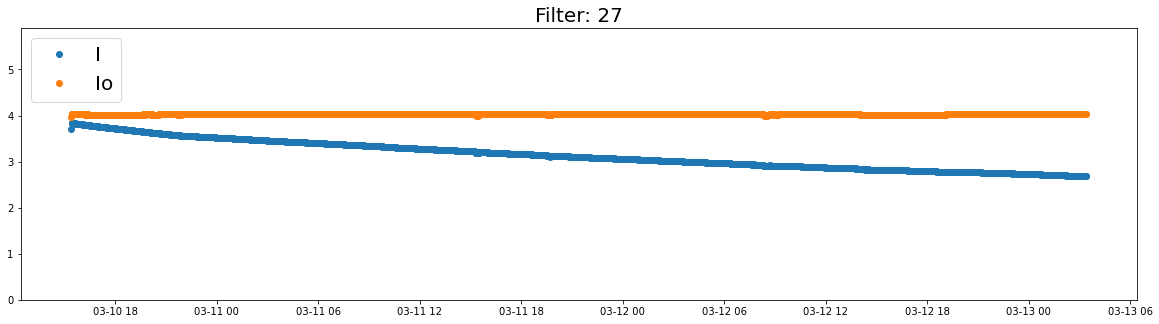

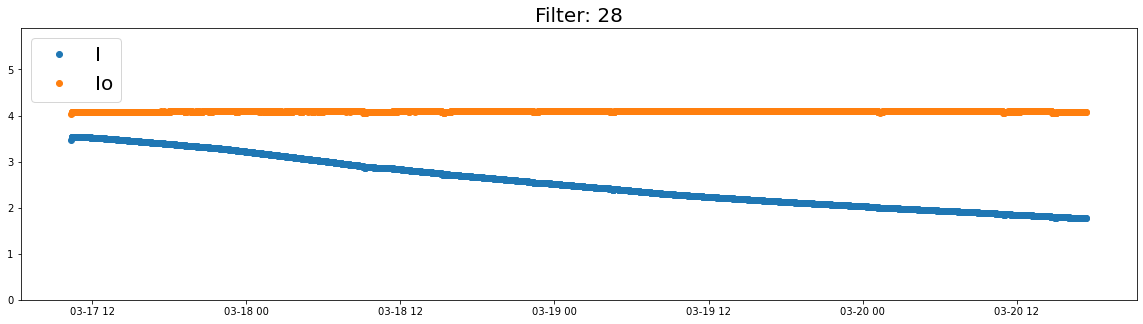

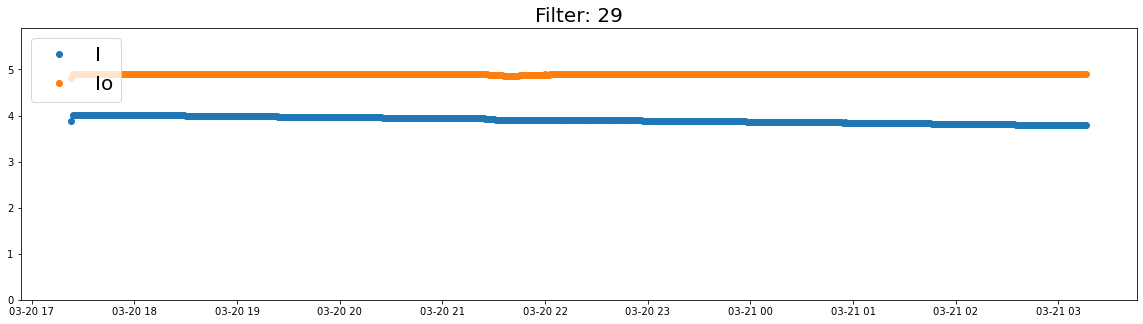

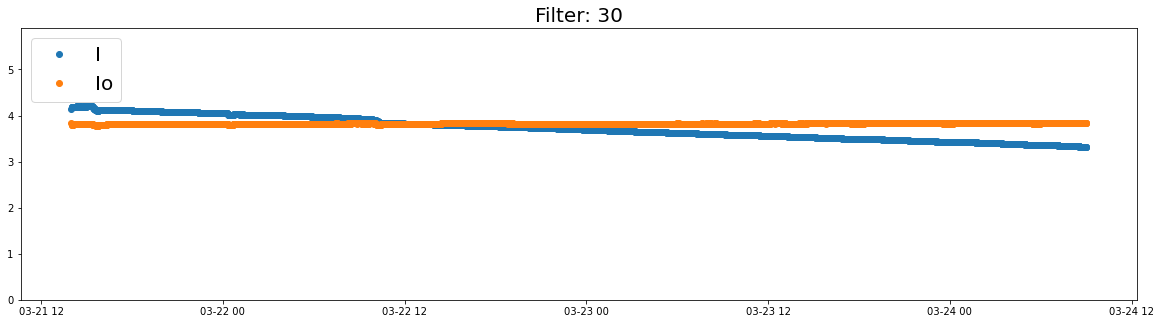

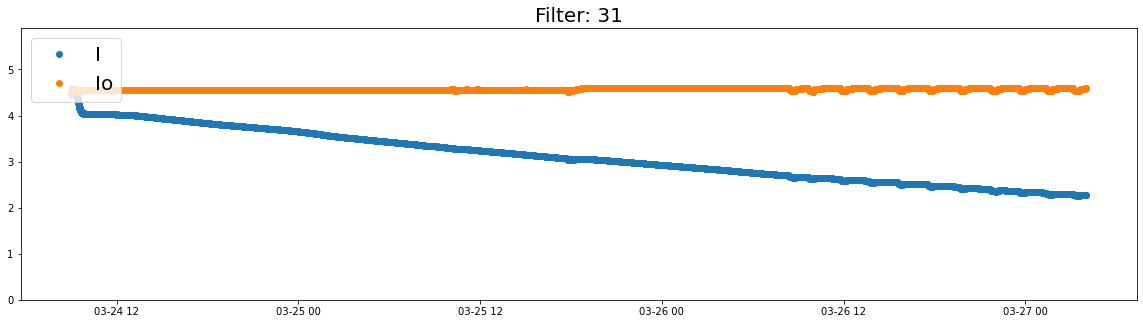

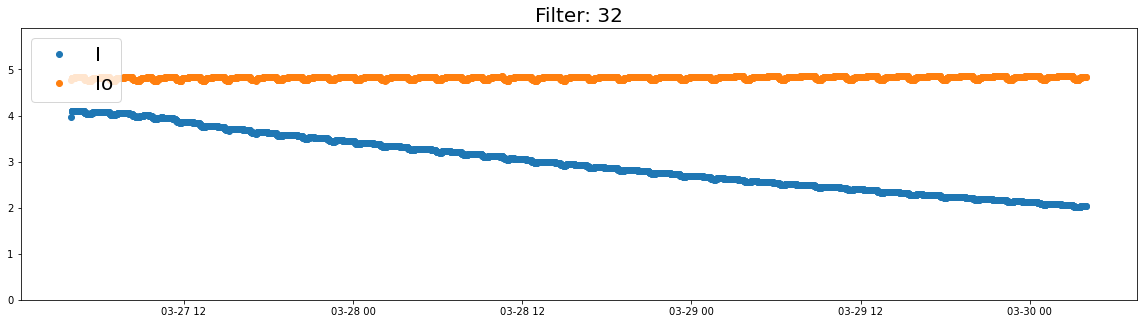

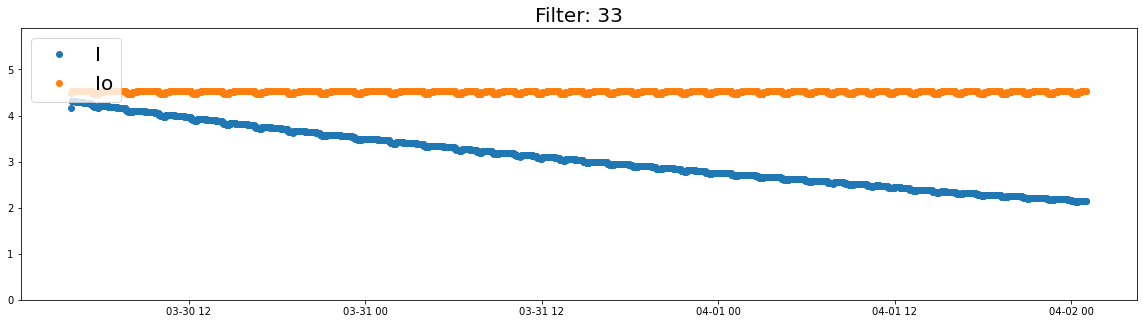

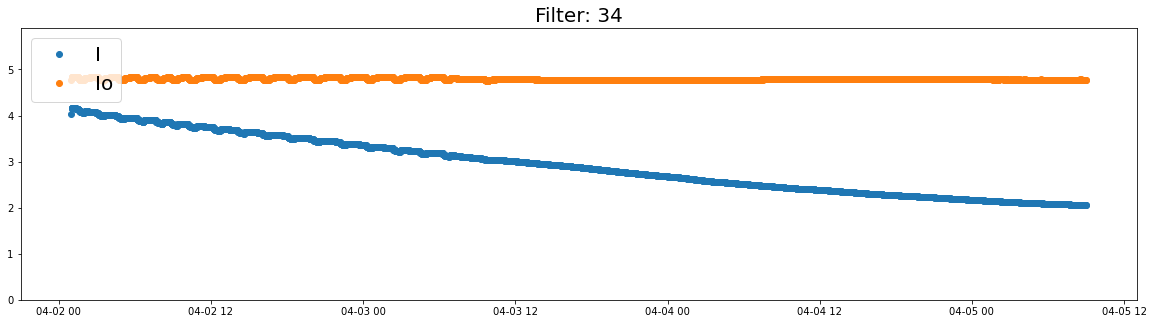

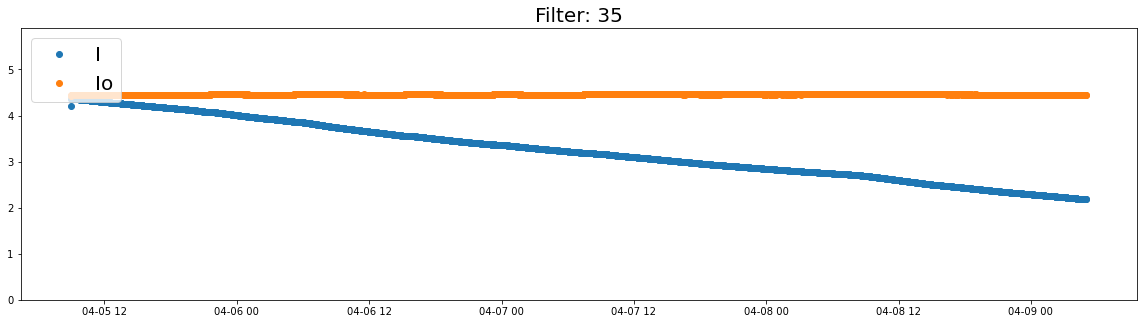

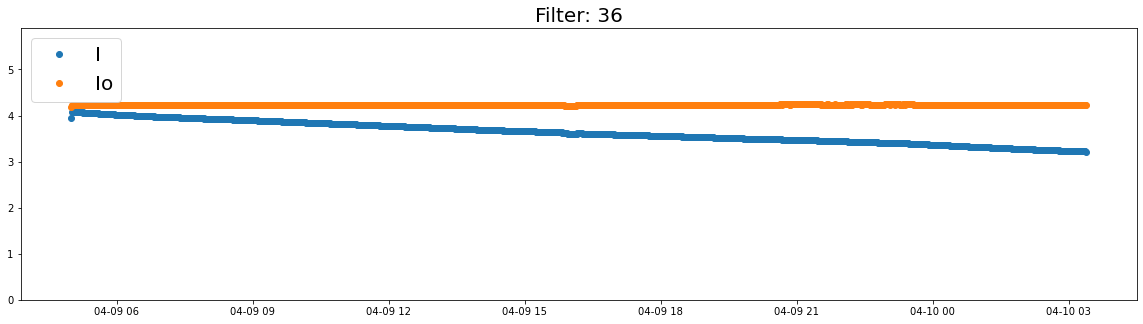

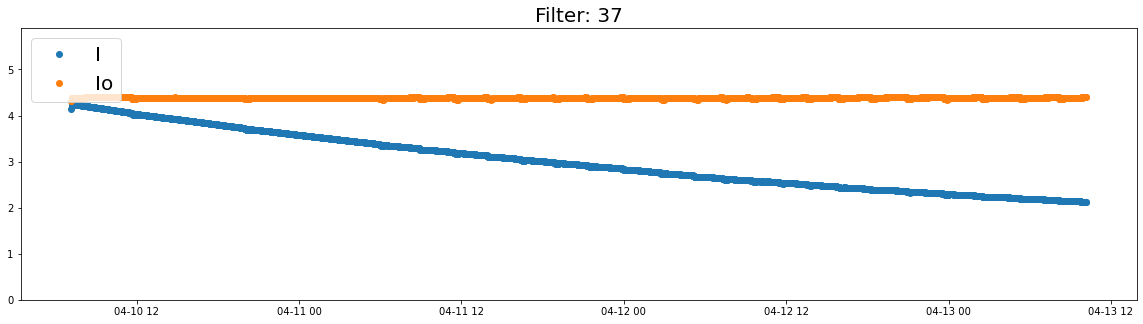

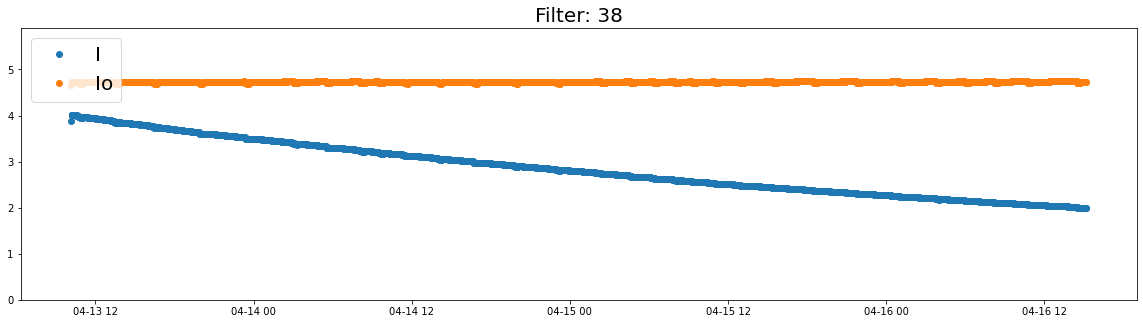

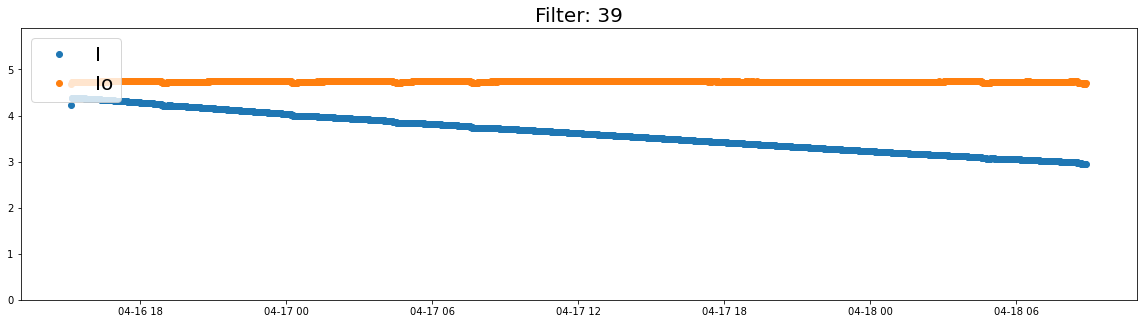

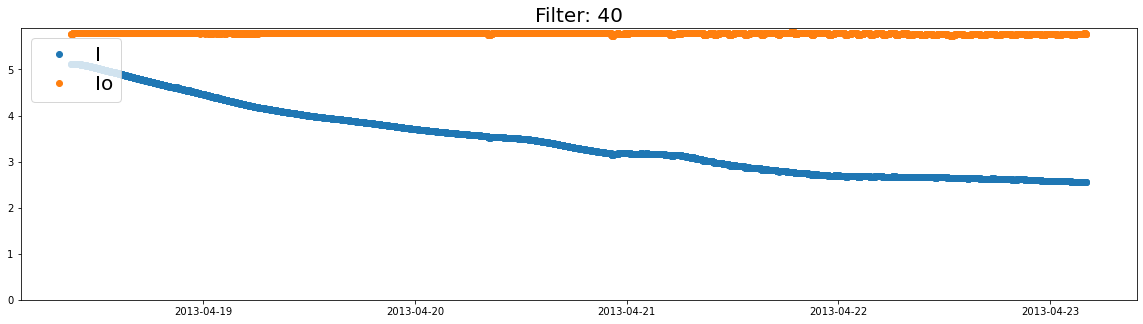

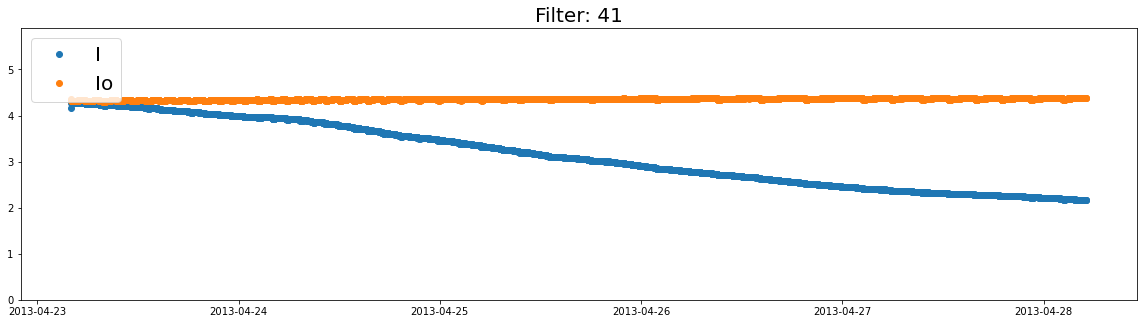

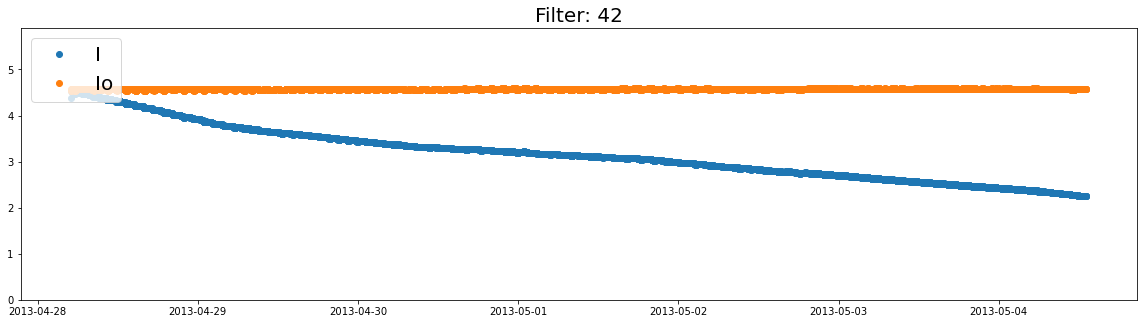

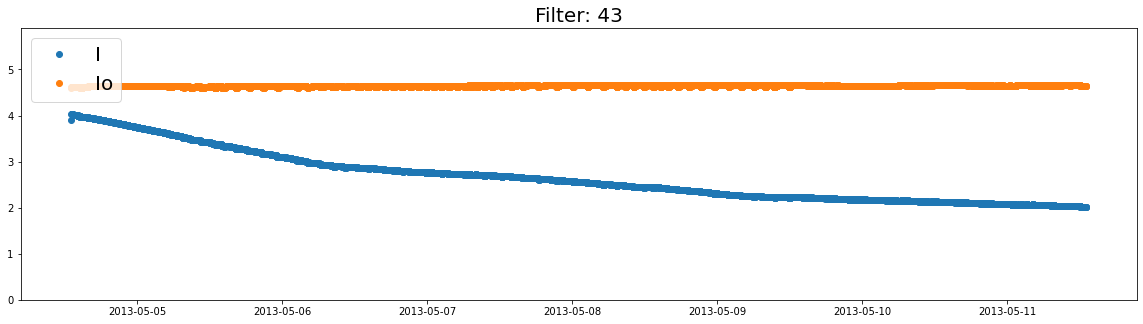

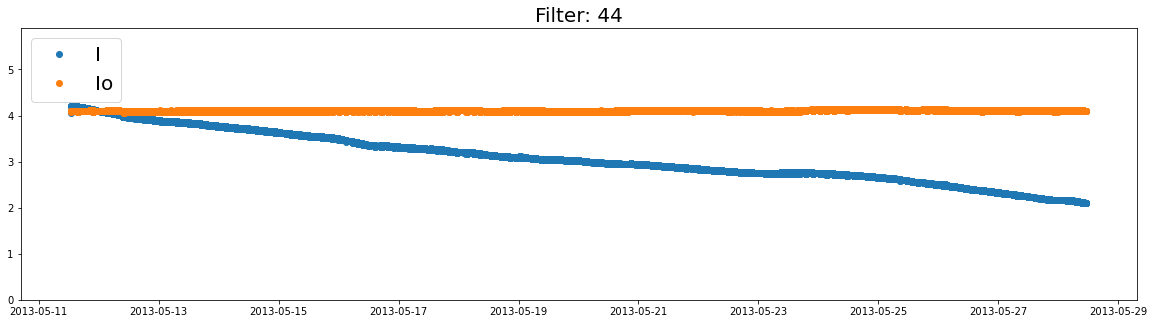

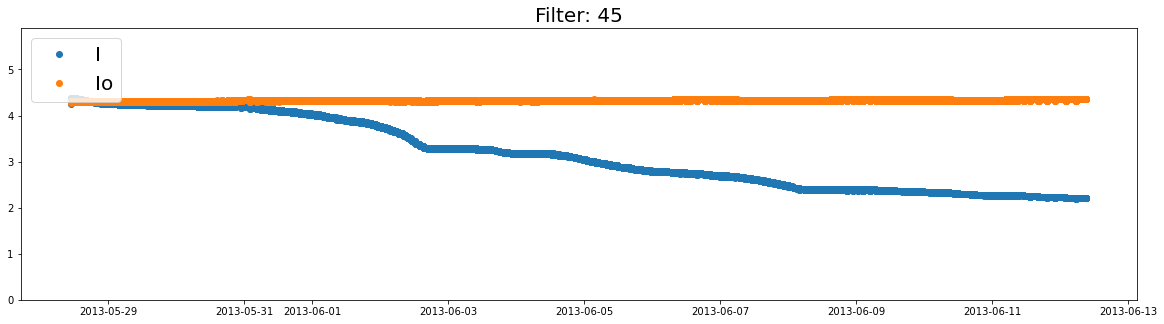

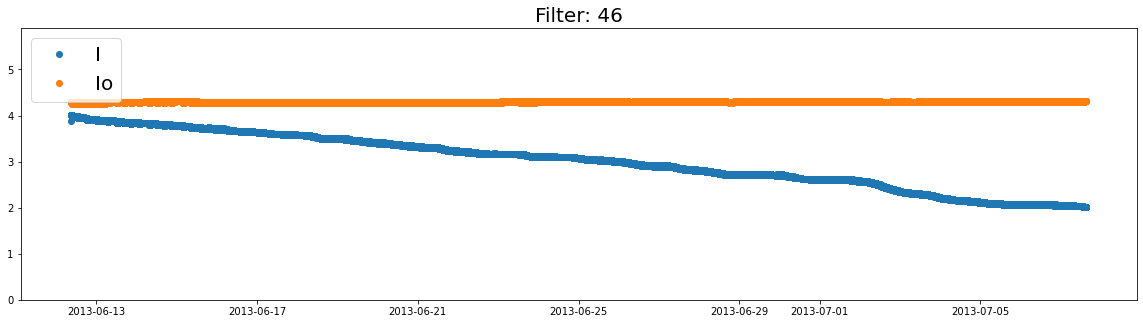

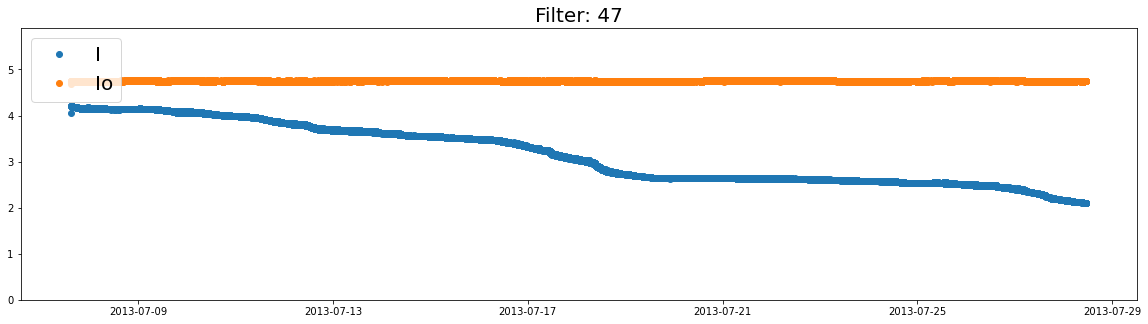

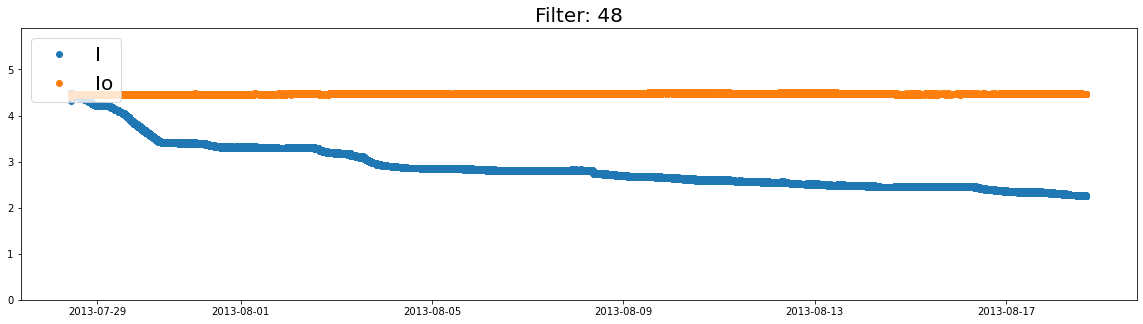

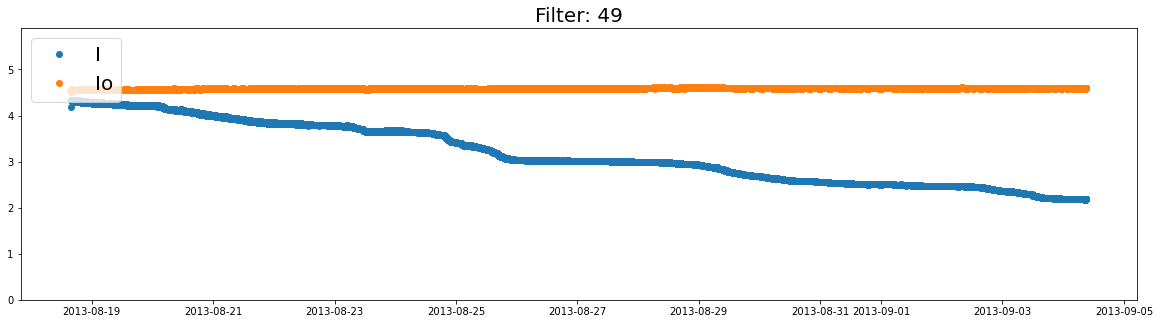

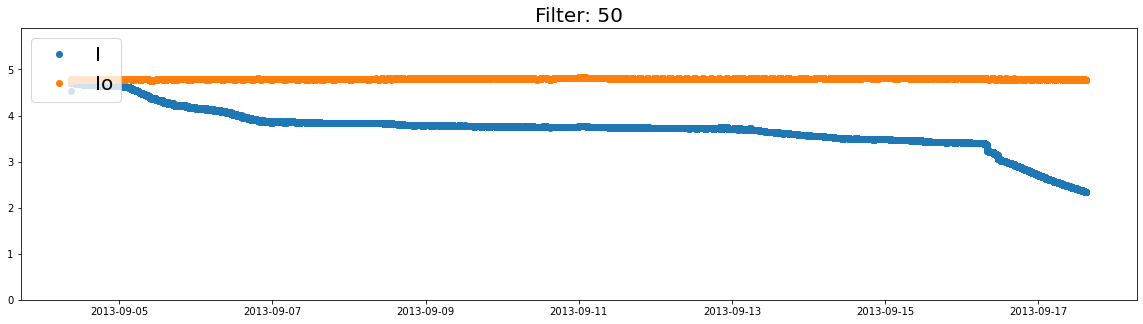

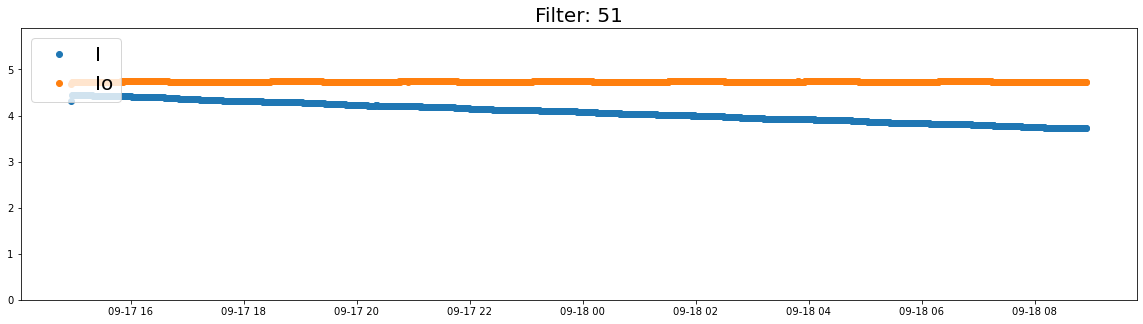

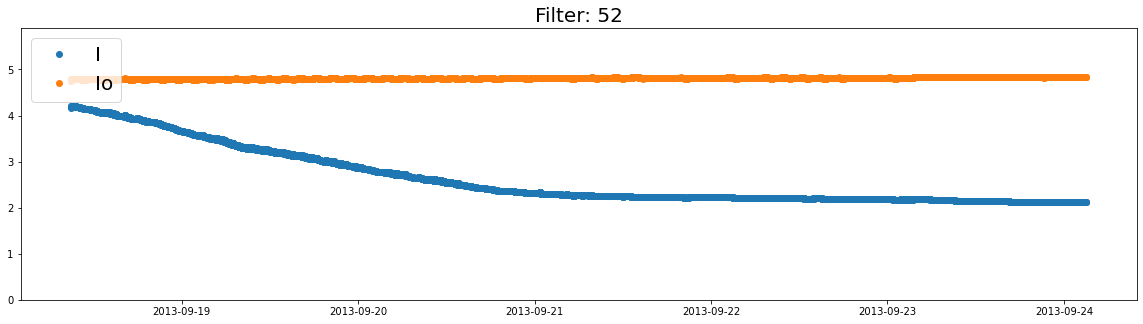

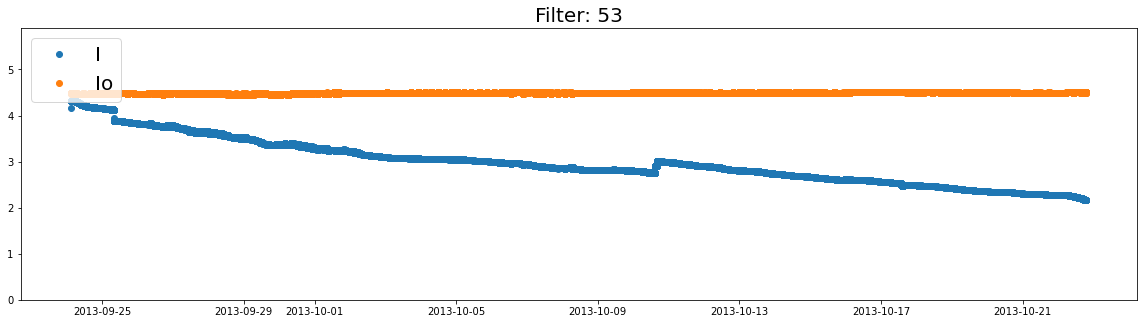

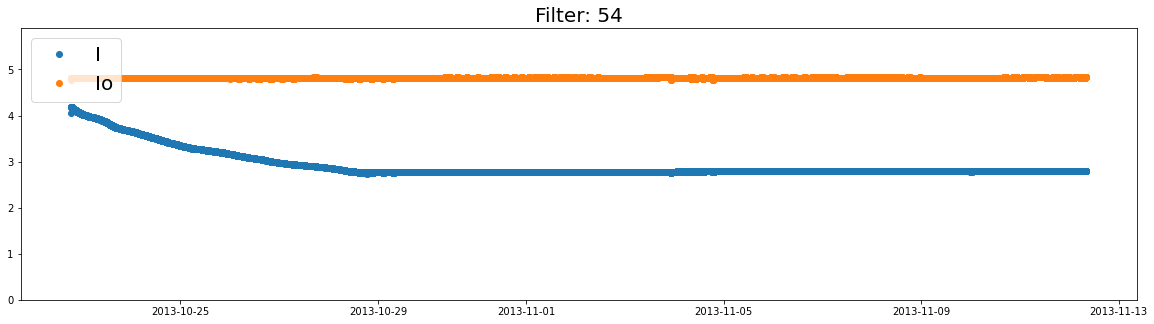

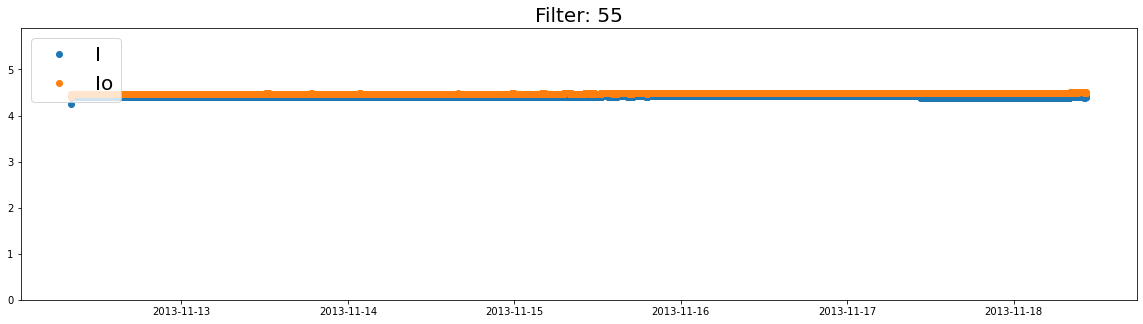

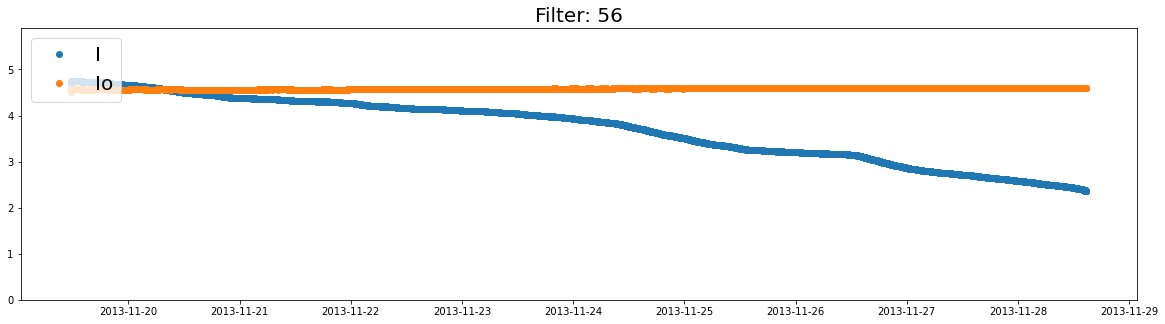

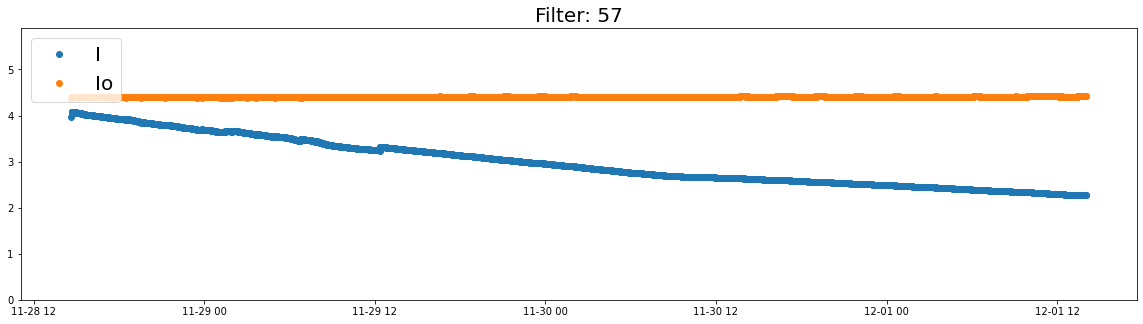

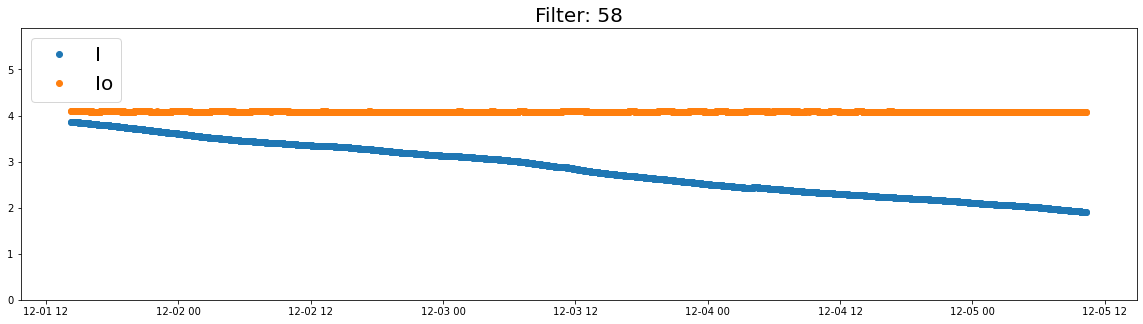

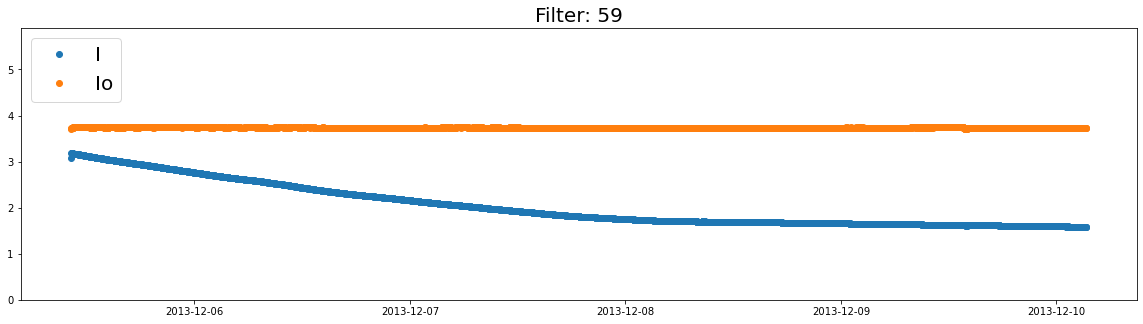

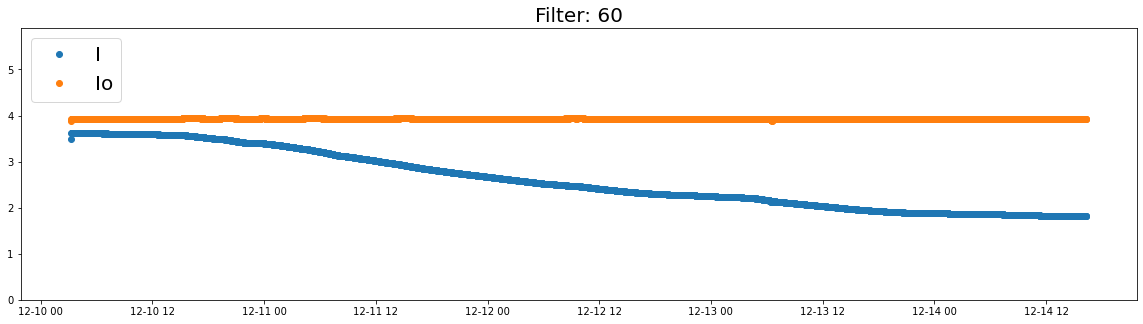

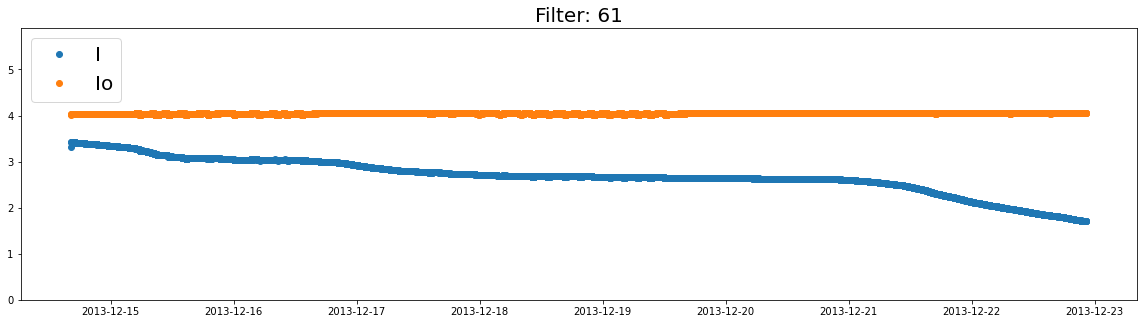

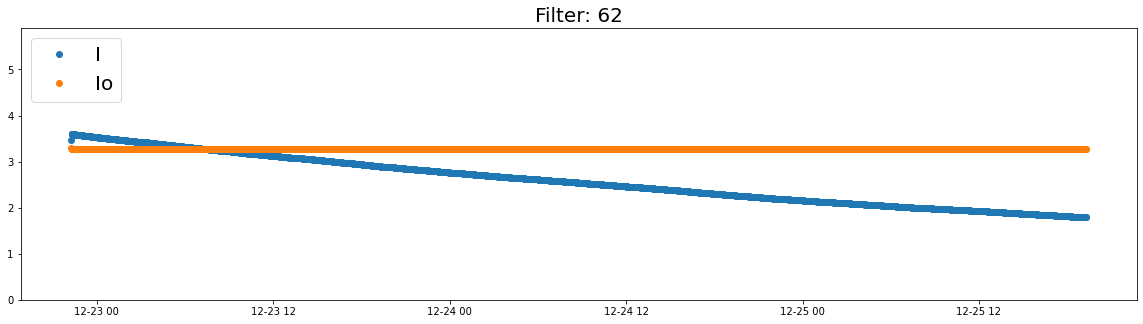

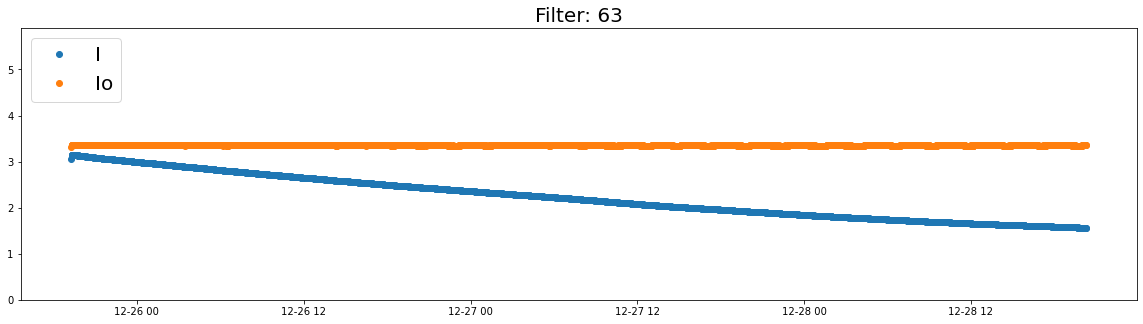

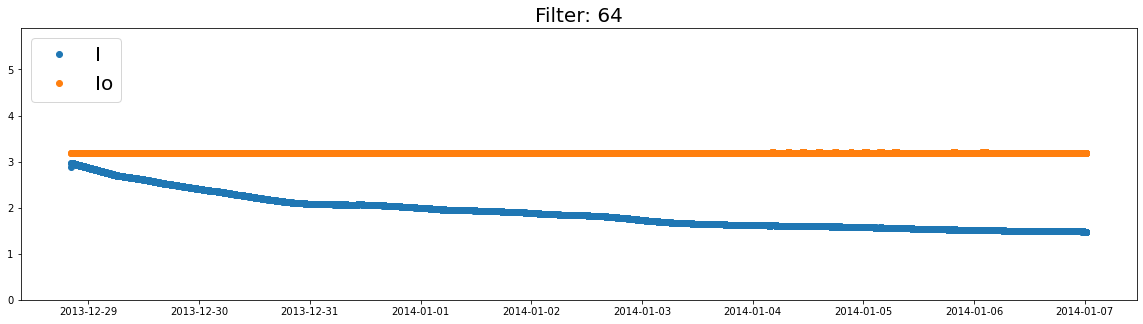

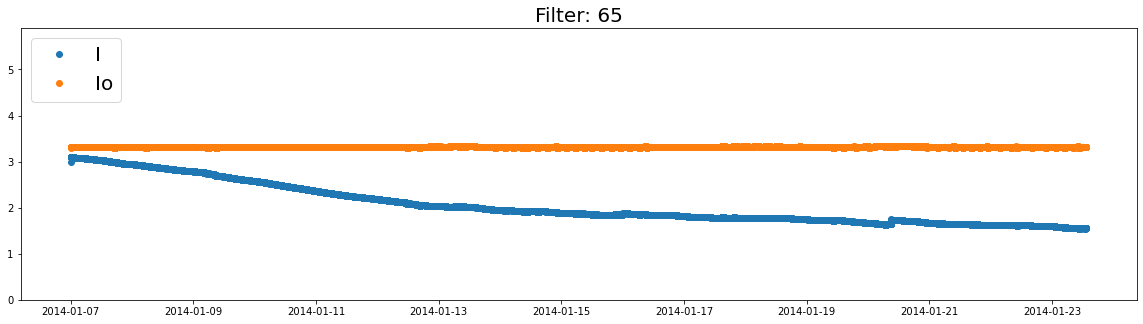

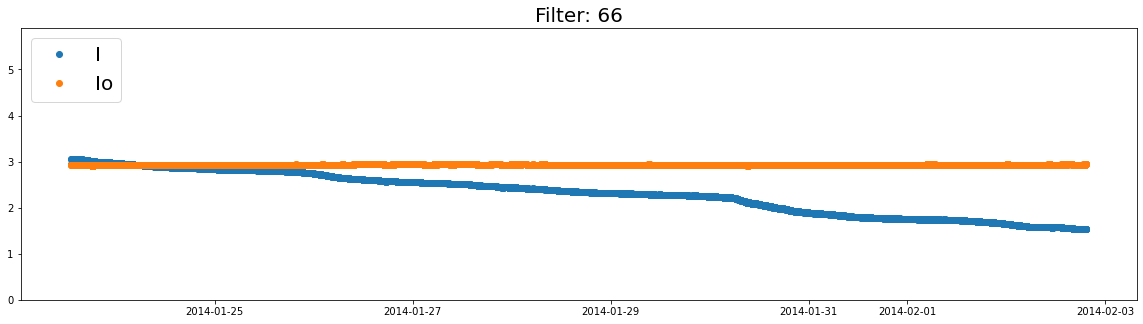

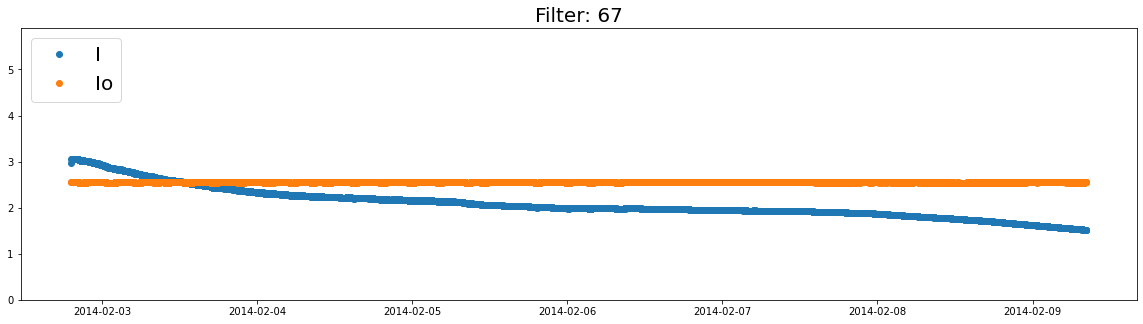

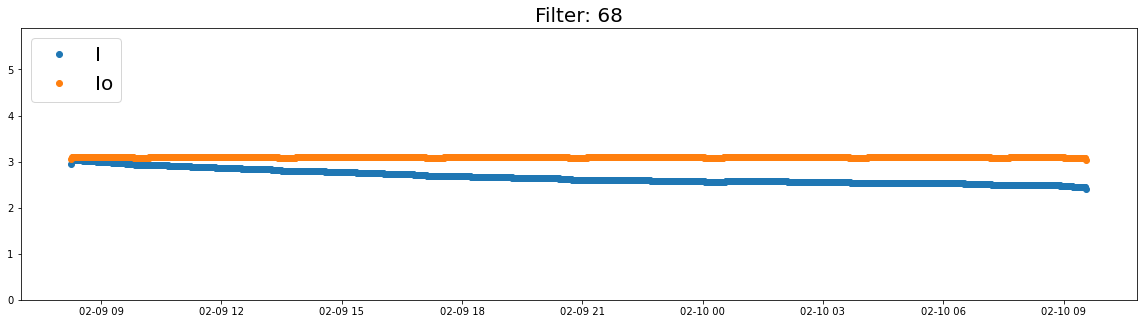

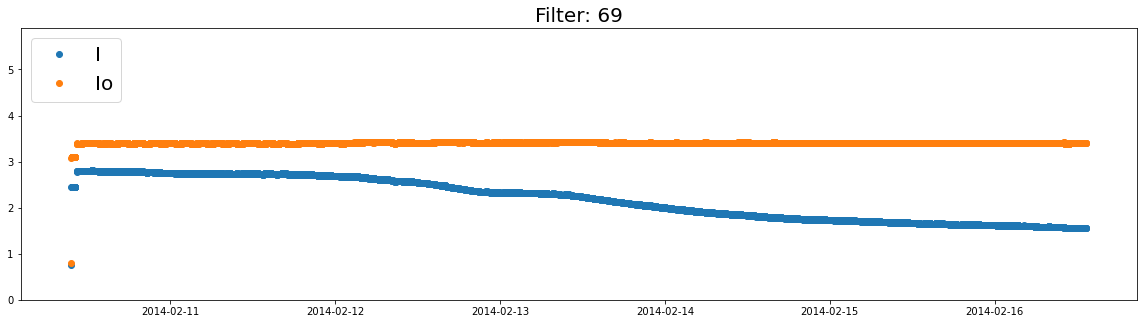

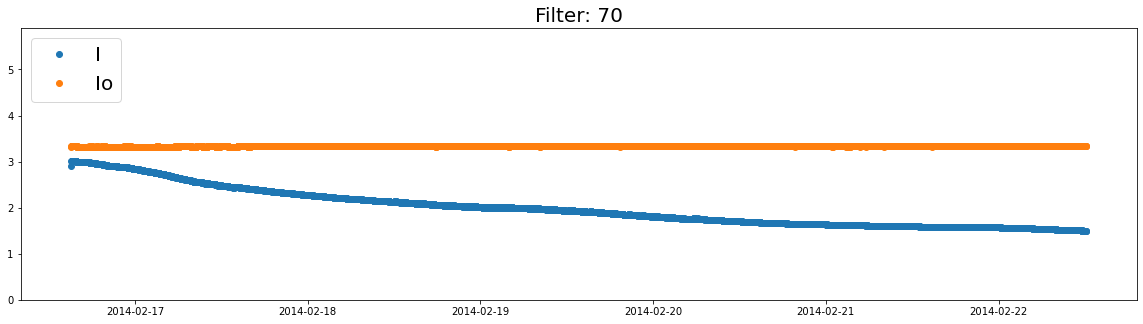

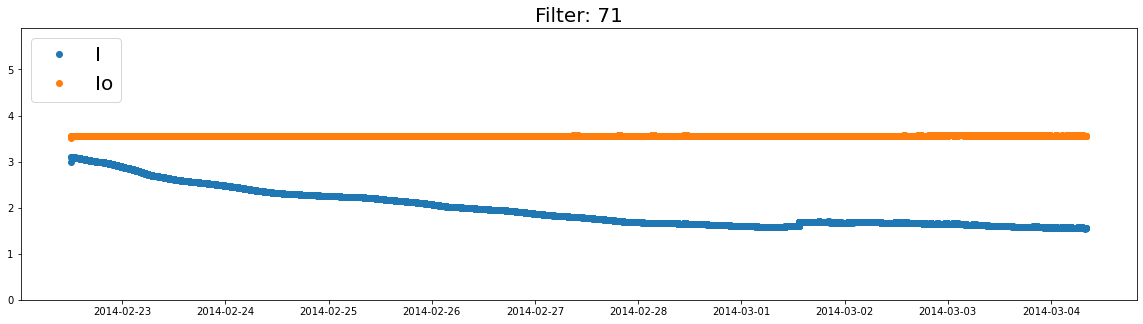

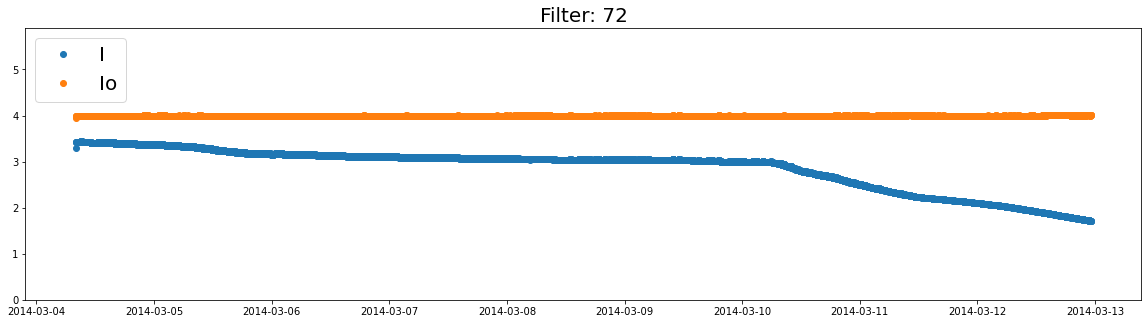

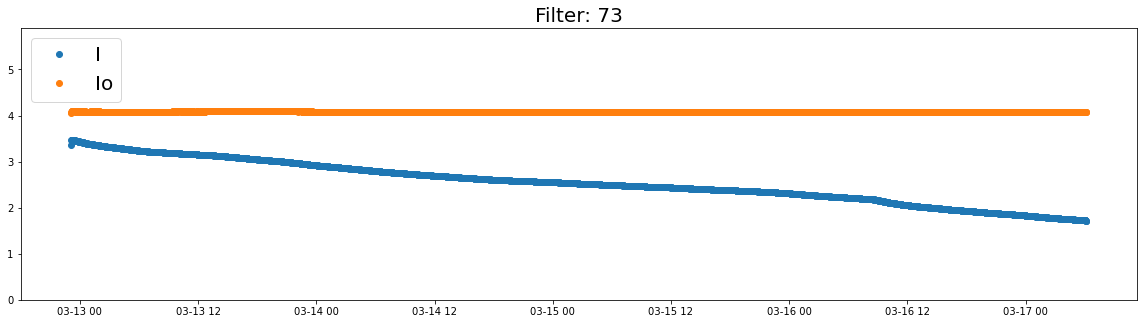

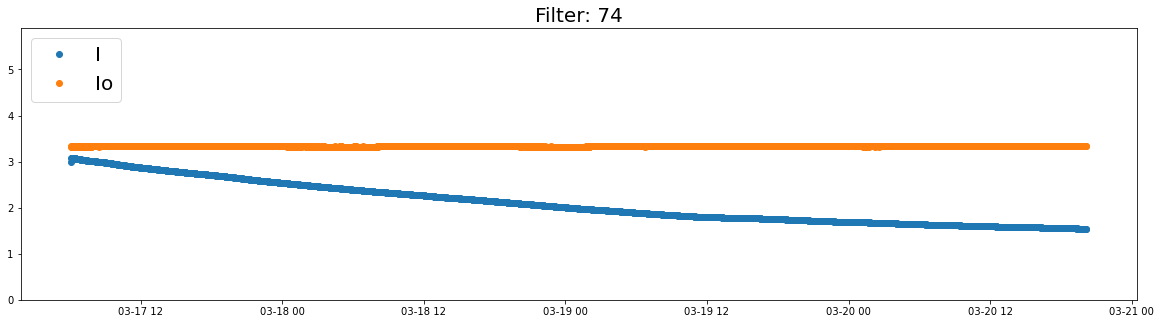

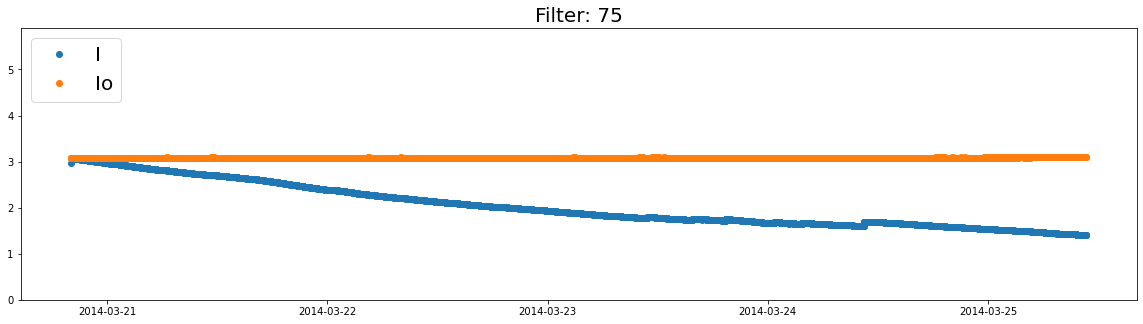

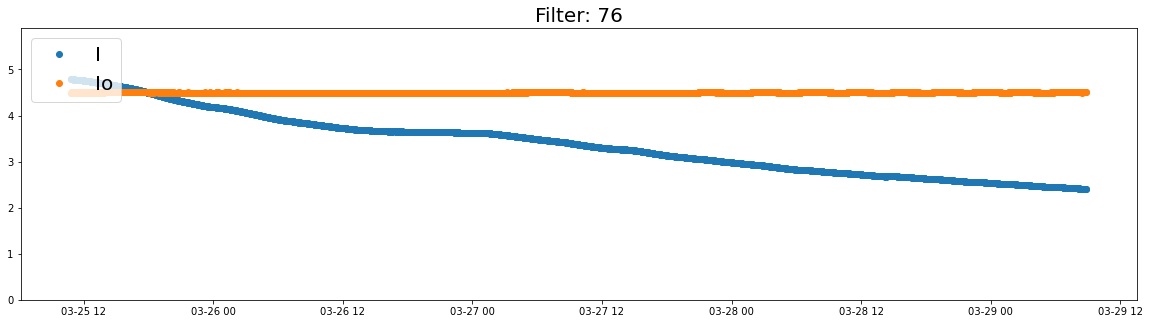

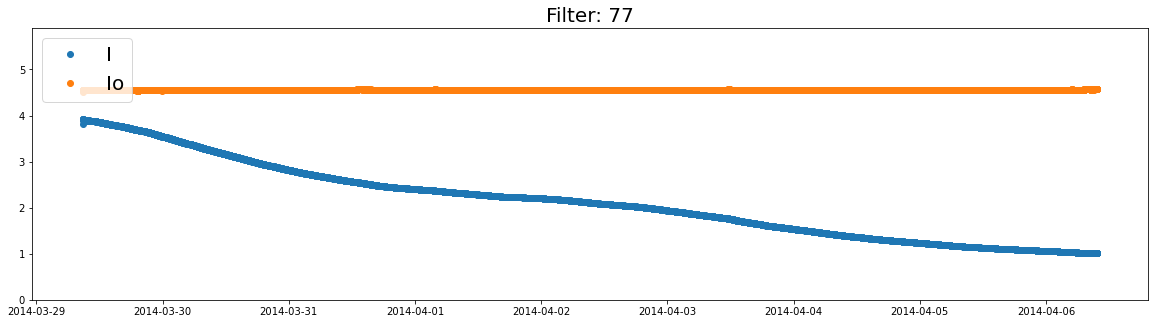

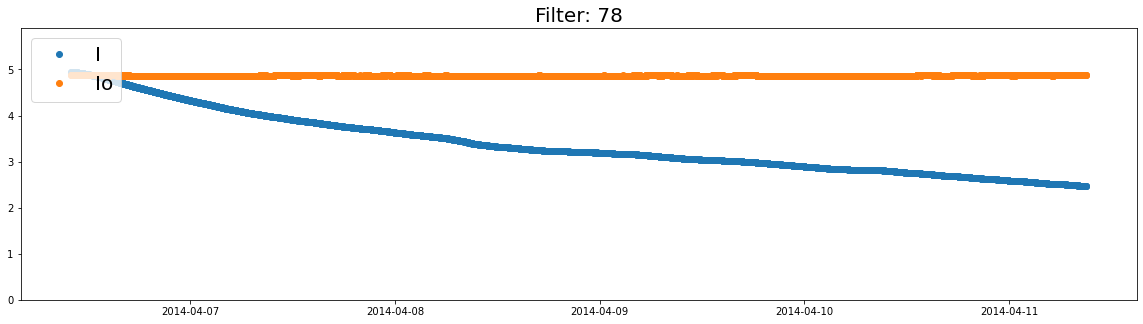

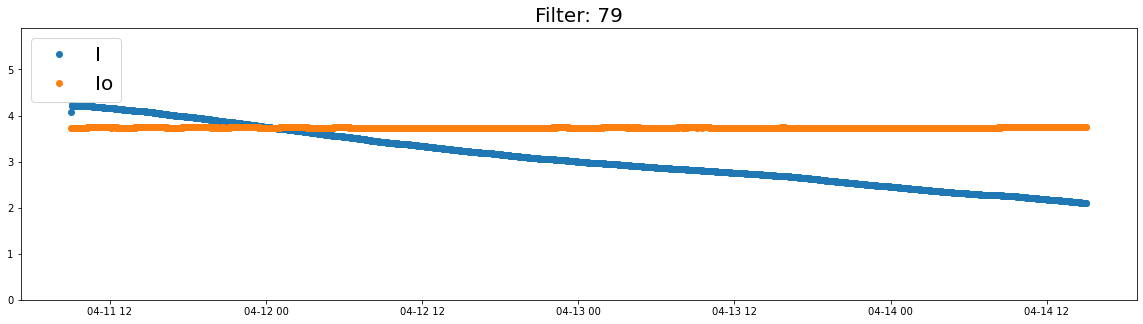

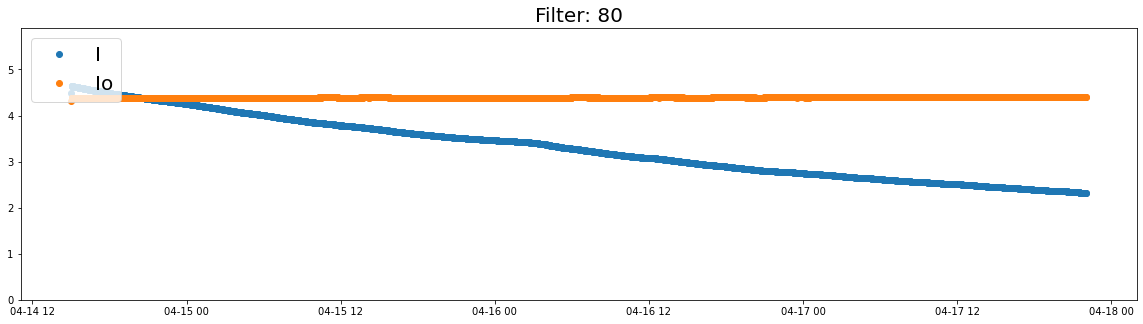

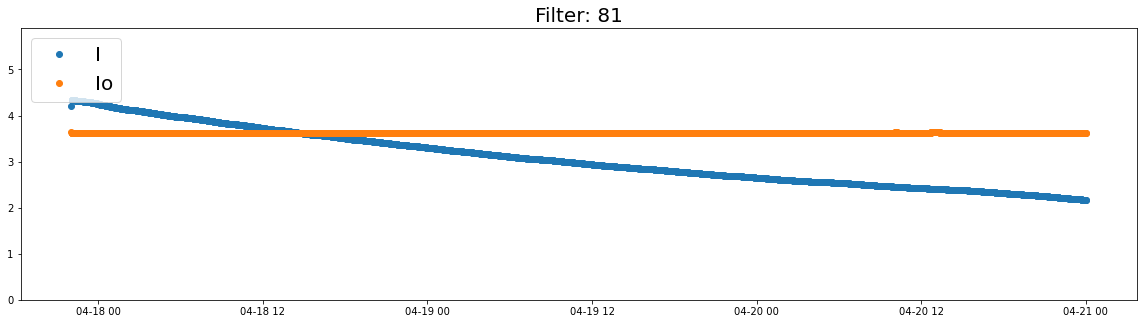

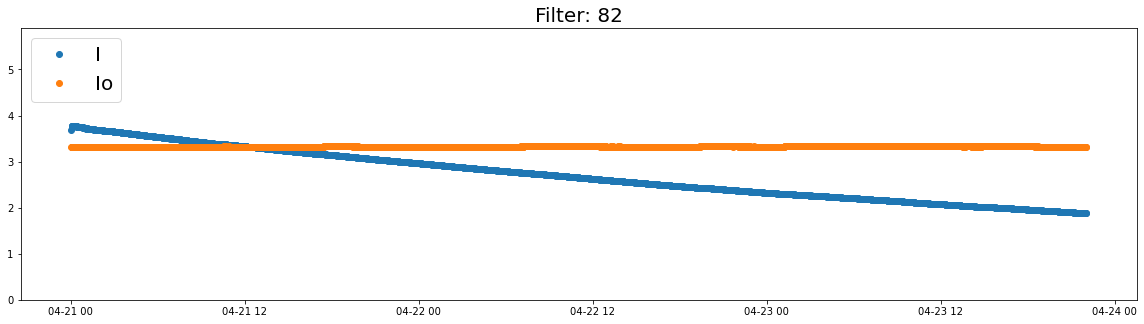

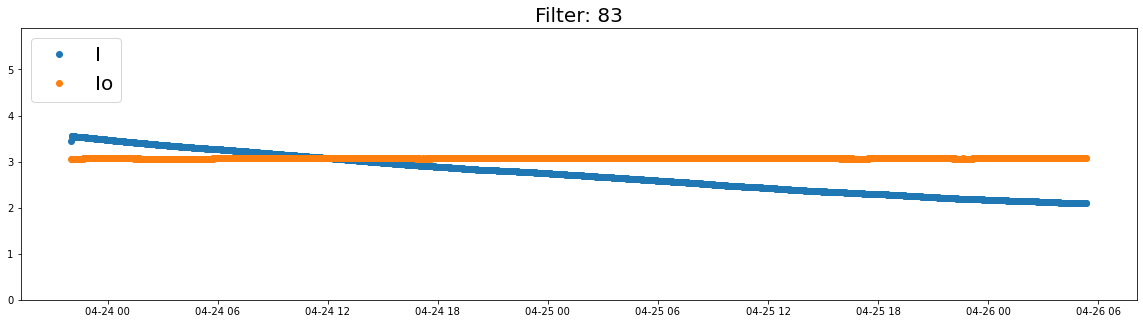

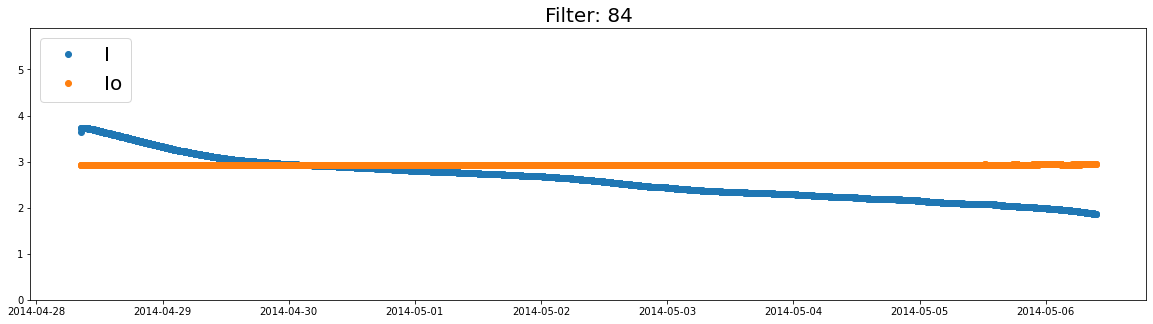

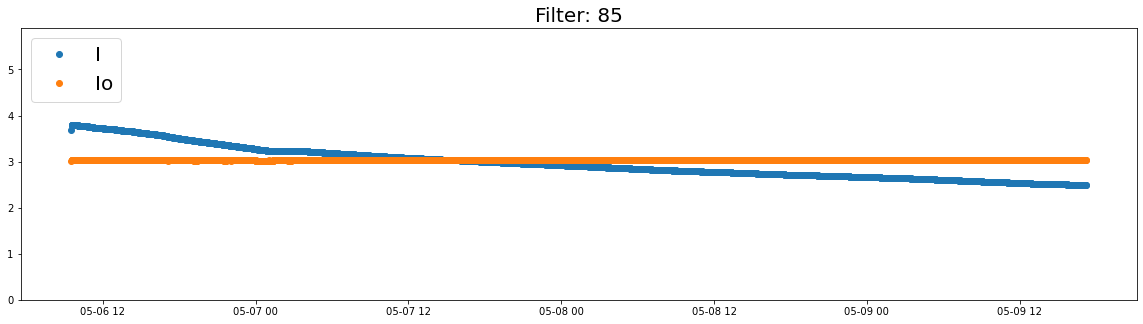

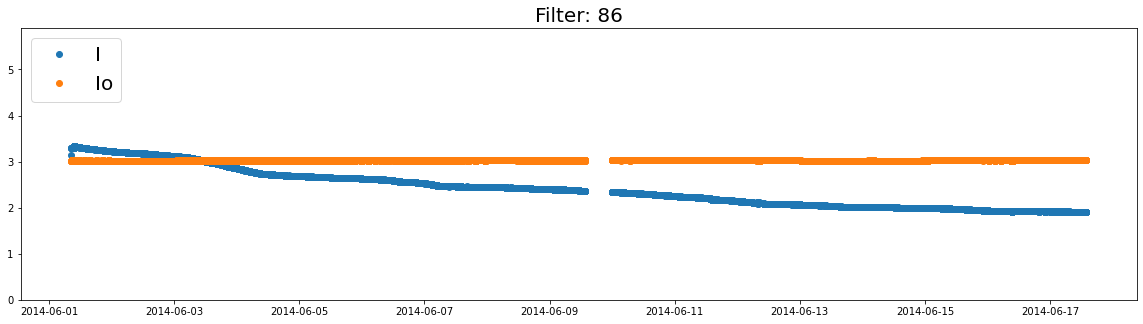

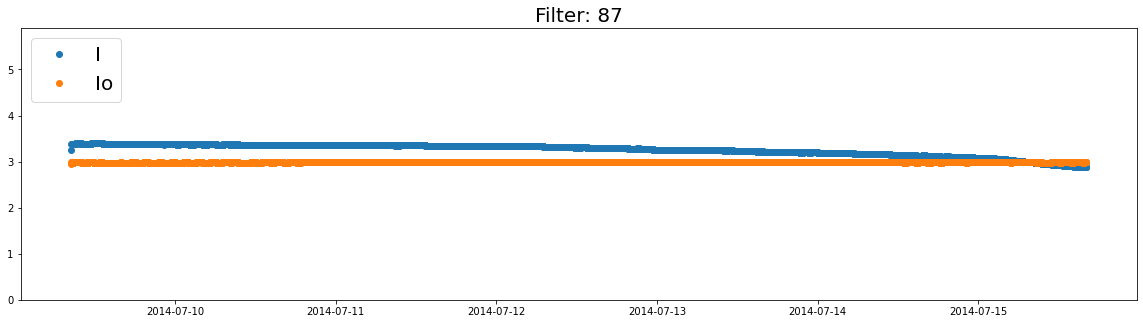

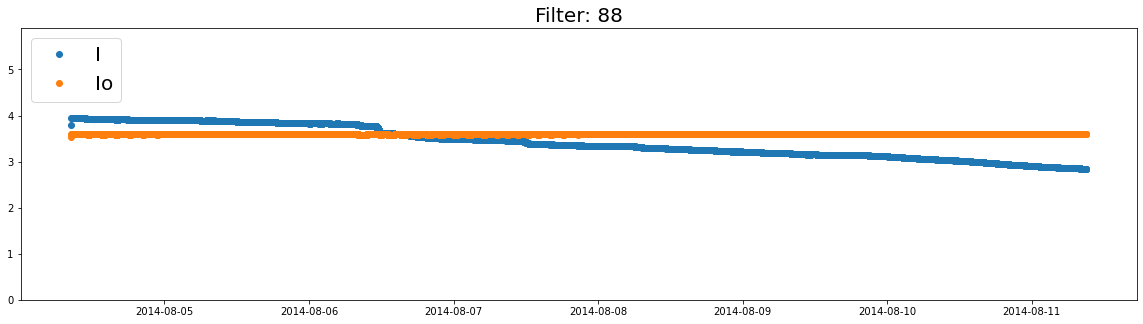

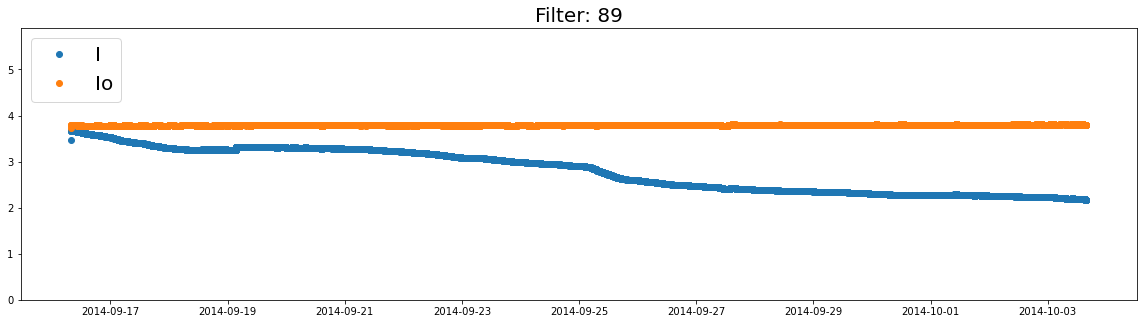

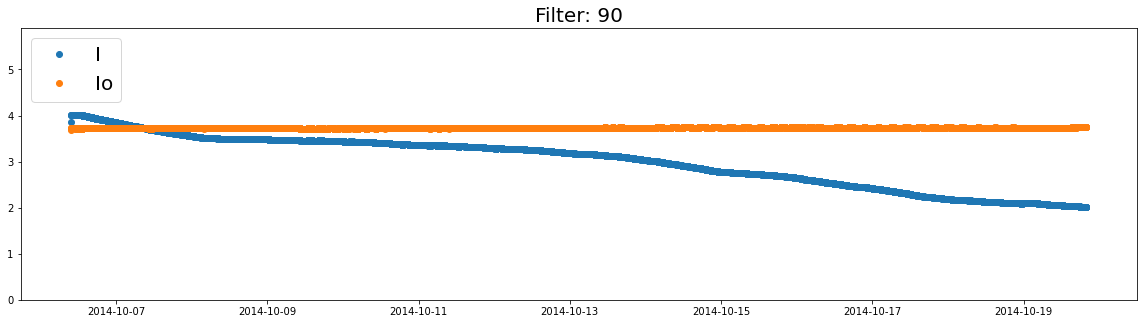

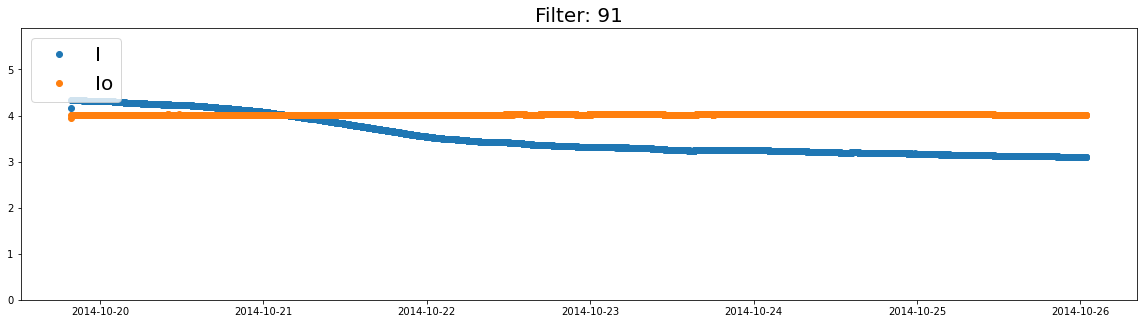

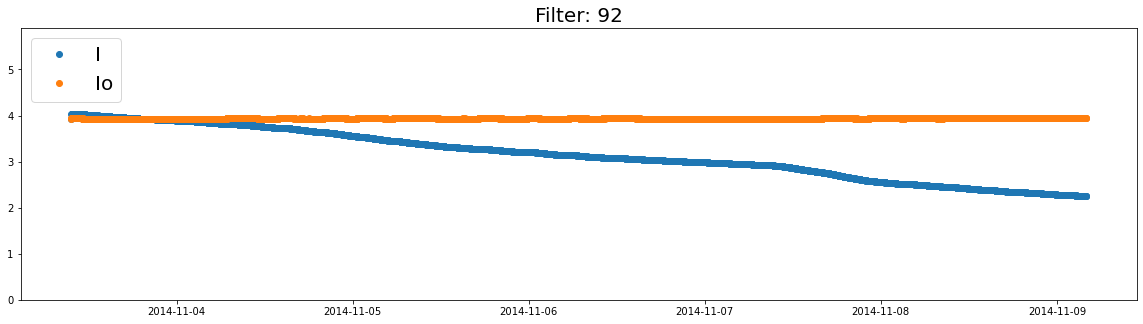

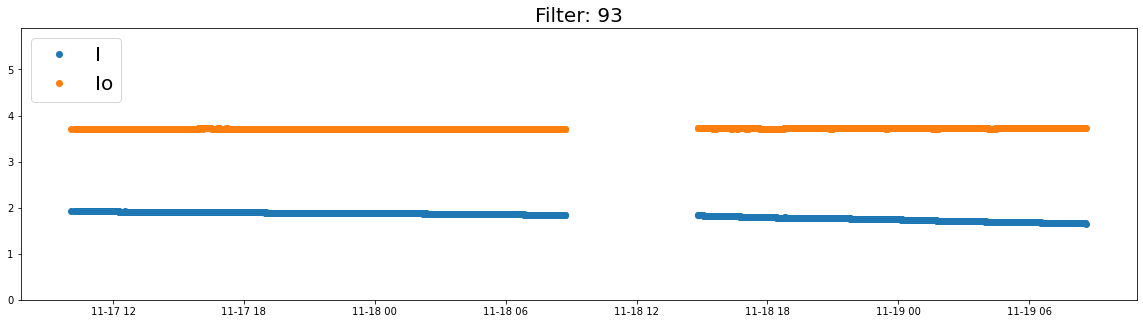

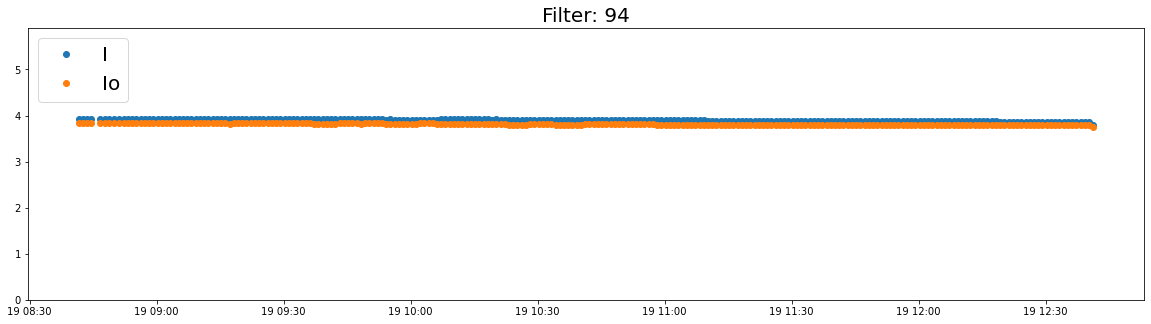

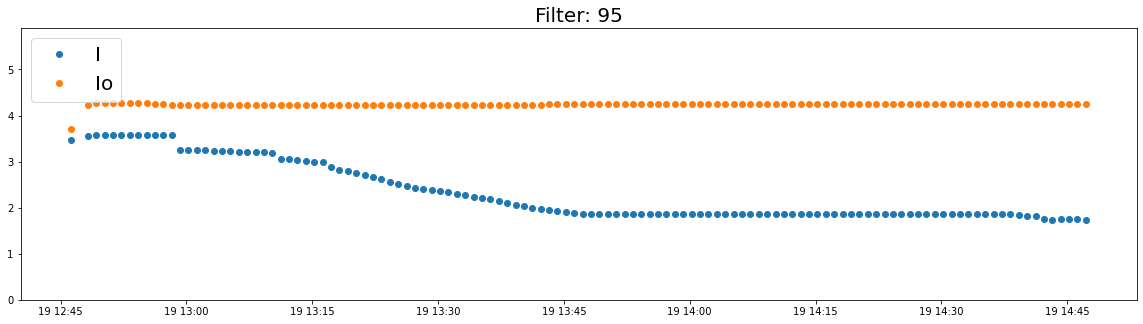

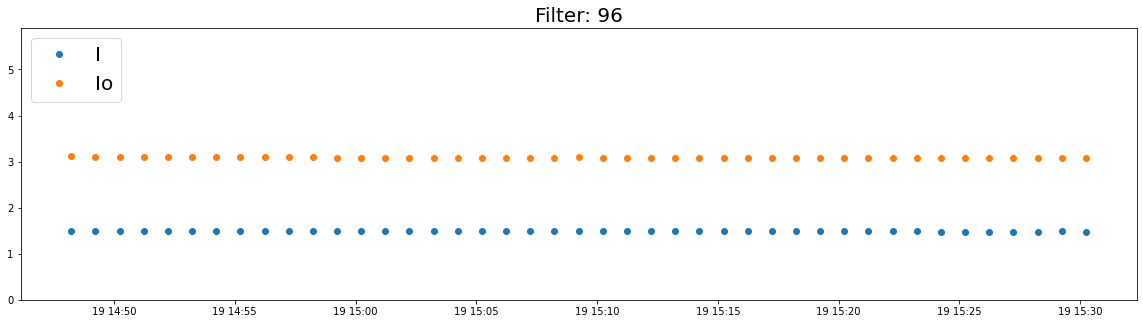

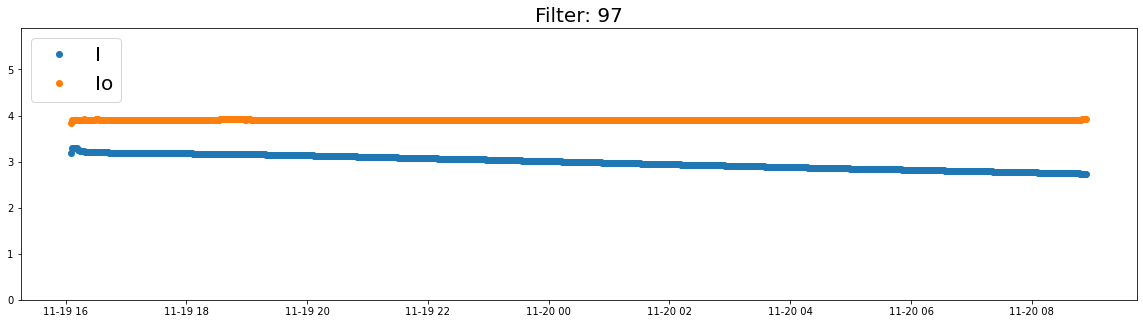

In [21]:
for i, df in enumerate(dfs[3:5]): #count, value in enumerate
    plot_each_filter(df, i)

Fig. 4 long list of examples of the filters and the lines representing the change of filter

After inspection a few things seem strange:

Slight oscillations/fluctuations: 

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

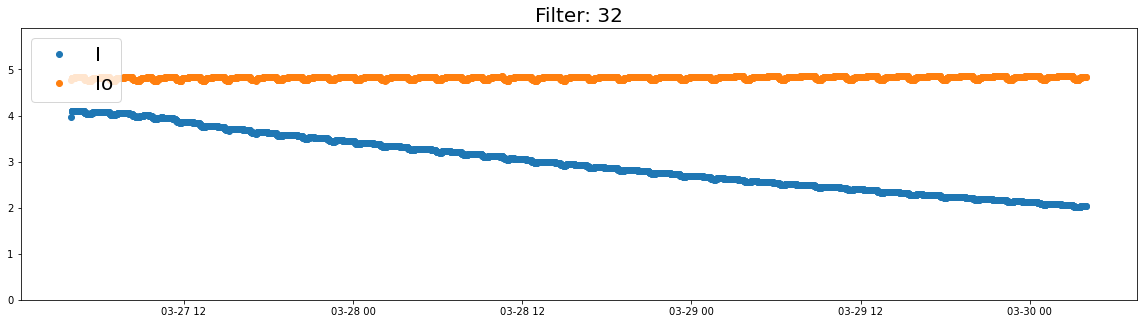

In [22]:
plot_each_filter(dfs[32], i=32)

I > Io: 

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

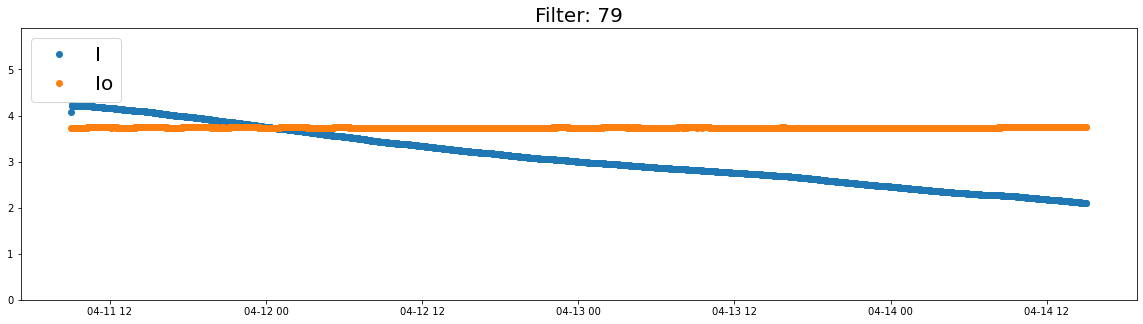

In [23]:
plot_each_filter(dfs[79], i=79)

In [24]:
def create_info_table(dfs):
    filter_changes_old = pd.DataFrame(columns=['Datetime', 'Size of filter'])
    for df in dfs:
        Datetime = df.index[0]
        size = len(df)
        filter_changes_old = filter_changes_old.append({'Datetime': Datetime, 'Size of filter': size}, ignore_index=True) 
    filter_changes_old.sort_values(by=['Datetime'], inplace=True)
    filter_changes_old = filter_changes_old.set_index('Datetime')
    return filter_changes_old

In [25]:
create_info_table(dfs)

,Size of filter
Datetime,
2012-11-18 08:46:49,274
2012-11-18 15:29:08,1017
2012-11-19 09:03:40,1656
2012-11-20 13:09:59,1196
2012-11-21 09:05:59,296
...,...
2014-11-17 10:04:59,2420
2014-11-19 08:41:37,239
2014-11-19 12:46:16,121


In [26]:
bad_filters = [96] #from inpection

In [27]:
print(len(dfs))
dfs = [j for i, j in enumerate(dfs) if i not in bad_filters]
print(len(dfs))

98
97


## Bond (1999) corrections

### Avergaing using a step inital of 15 minutes

In [28]:
Area = 8.04*10**(-6)  #surface area of filter
Filter_constant = 2 #spot correction

The formula for the Bond correction is: 
<br>
$\sigma_{(t)} = A/Vln(I(t-\Delta t)/I(t)) \cdot 1/1.317 \cdot \tau + 0.866 - 0.016 \cdot \sigma_{sp}$

### Spot correction

\begin{equation}
F_{spot} = \frac{\sigma_{calib}}{\sigma_{PSAP}} = (\frac{D_{meas}}{D_{calib}})^{2} = 2
\end{equation}

### Flow calibaration

$F_{flow} = $ for this instrument there no flow correction factor used

### PSAP Correction 

The adjustment to and uncertaintiesin the PSAP are summarized below:

\begin{equation}
\sigma_{ap} = \frac{\sigma_{adj} - K_{1}\sigma_{sp} + \epsilon_{slope} + \epsilon_{noise}}{K_{2}}
\end{equation}

### Instrument Precision

where K1 = 0.02 ± 0.02, K2 = 1.22 ± 0.20, sadj is the reported value after the flow and spot size corrections, $\sigma_{sp}$ is the scattering coefficient at 550nm, and $\epsilon_{slope}$ + $\epsilon_{noise}$ are defined in Equations (7) and (8) in Bond (1999). $\epsilon_{slope}$ = 0.06$\sigma_{ap, meas}$ and $\epsilon_{noise}$ = 0.18$\sqrt{\tau_{0}/\tau}$, $\tau$ is the averaging time and $\tau_{0}$ = 24 min.

applied after flow and spot size corrections - $\sigma_{sp}$ is the scattering coefficient at 550 nm

The idea here to to reorganise the data set into values every minute and then a apply a rolling mean

In [29]:
df_averaging_times = []
datasets = []
for i, df in enumerate(dfs):
    time_step = 15
    filter_length = len(df)
    
    if filter_length > time_step: #filter must be larger than time step
    
        df = df.copy()
        df = df.resample('min').mean() #the values should be every minute
        idx = pd.date_range(min(df.index), max(df.index), freq='60s') #create 
        df = df.reindex(idx, fill_value=np.nan) #fill dataframe will missing values
        df = df.rolling(window=3,min_periods=3,center=True).mean() #apply a rolling mean

        times = df.index.to_numpy()
        Is = df.I.to_numpy()
        Qs = df.qobs.to_numpy()

        times = times[:-time_step]
        filter_num = np.ones(len(times))*int(i+1)

        ln_tr = np.log((Is[:-time_step] / Is[time_step:])) 
        Q = np.convolve(Qs, np.ones(time_step)/time_step, mode='valid')/1000
        volume = Q*time_step
        diff = len(volume) - len(times)
        volume = volume[:-int(diff)]

        absorption_ln = ((Area/volume)*(ln_tr))
        absorption_abjusted = absorption_ln*Filter_constant

        Ios = df.Io.to_numpy()
        R = (0.355 + 0.5398*Ios[:-15])    

        dataset = pd.DataFrame({'Datetime': times, 'filter_num':filter_num, 'volume': volume, 
                                'ln_tr': ln_tr, 'abs_ln': absorption_abjusted, 'R':R})
        datasets.append(dataset)
    else:
        pass

df_averaging_times = pd.concat(datasets)
df_averaging_times.set_index('Datetime', inplace=True)

In [30]:
df_averaging_times.volume.mean()
df_averaging_times.abs_ln.mean()

8.448070465089535e-07

In [31]:
def inital_plot(df, var):  
    idx = df.columns.get_loc(str(var))
    plt.figure(figsize=(15,8))
    plt.plot(df.index, df.iloc[:,idx].values, 'o', ms=0.5)
    plt.ylabel('absorb ln', fontsize=15)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

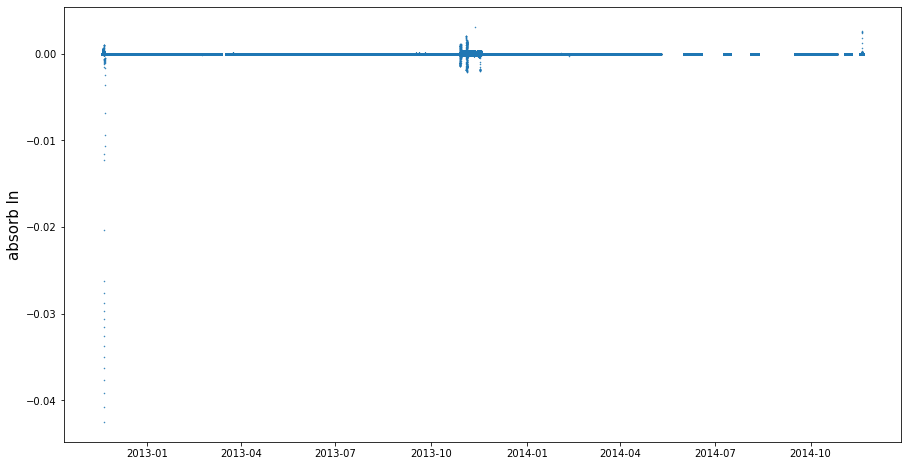

In [32]:
inital_plot(df_averaging_times, var='abs_ln')

Fig. 7 ((Area/volume)*(ln_tr))*Filter_constant plotted

## Introduce neph data

In [33]:
def remove_neph(df, abs_var):
    K1 = 0.02
    K2 = 1.22
    df['abs_neph'] = (df[abs_var]*10**6/df['R'] - K1*df['scat550'])/K2
    return df   

In [34]:
def append_files(path):    
    appended_data = []    
    for file in glob.glob(path):   
        print(file)
        number_files = len(glob.glob(path))
        data = pd.read_csv(file, index_col=0, parse_dates=True)
        appended_data.append(data)        
    appended_data = pd.concat(appended_data,sort=True)
    return appended_data

In [35]:
#this neph data is of an hourly resolution and has not been corrected
inpath_optical_data = 'C:\\Users\\DominicHeslinRees\\Documents\\ACP_2020\\finals_data_files\\finals_data_files\\hourly_clean\\*.dat'

In [36]:
optical_data = append_files(inpath_optical_data)

C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\1999.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2000.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2001.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2002.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2003.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2004.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2005.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2006.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\finals_data_files\hourly_clean\2007.dat
C:\Users\DominicHeslinRees\Documents\ACP_2020\finals_data_files\

In [37]:
df_abs_hourly = df_averaging_times.resample('60T').mean() #resample hourly 
df_abs_neph = pd.merge(df_abs_hourly, optical_data, how='inner', left_index=True, right_index=True) #merge the two dataframes
df_abs_neph = remove_neph(df_abs_neph, abs_var='abs_ln') #remove scattering from PSAP values
df_abs_neph.rename(columns={'volume':'volumne_OLD_PSAP'}, inplace=True)  #rename

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

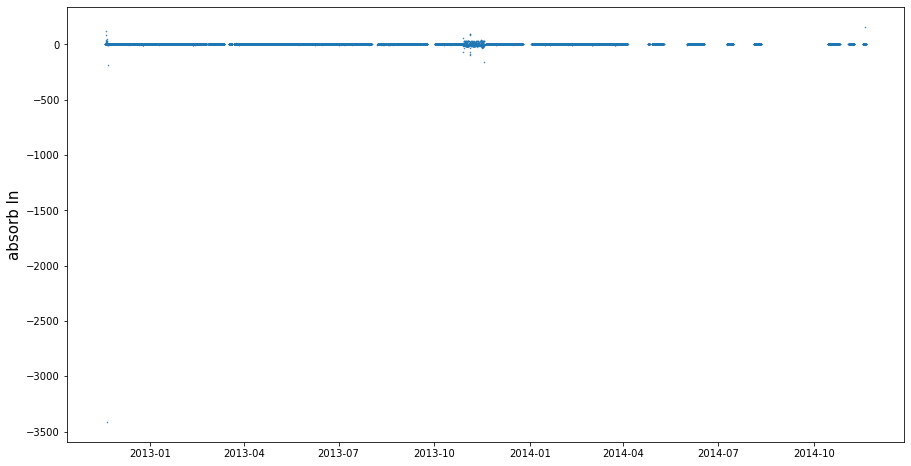

In [38]:
inital_plot(df_abs_neph, var='abs_neph')

In [39]:
def remove_extreme_values(df, var):
    print("Mean :" + str(df[var].mean()))
    return df[np.abs(df[var]-df[var].mean()) <= (3*df[var].std())]

In [40]:
df_abs_neph_clean = remove_extreme_values(df_abs_neph, var='abs_neph')
print(df_abs_neph_clean.abs_neph.mean())

Mean :0.14006980342072833
0.41447414951627987


In [41]:
df_abs_neph_clean.to_csv(out_path_datafiles+'df_abs_neph_clean_bond.dat', index=True)

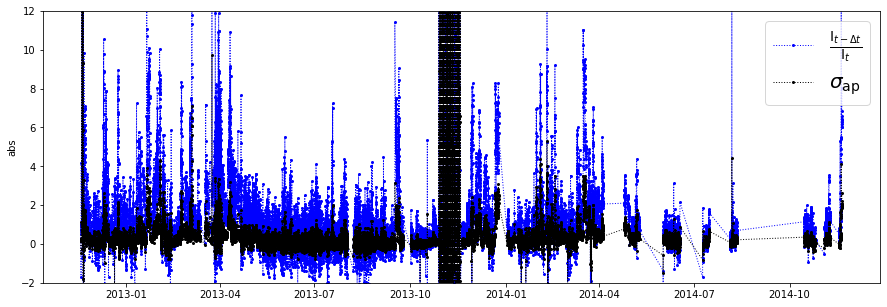

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_abs_neph_clean.index, df_abs_neph_clean.abs_ln*10**6, 'o', ms=2, ls=':', lw=1, mec='blue', c='blue',
        label = r'$\frac{\mathrm{I}_{t-\Delta t}}{\mathrm{I}_{t}}$')
ax.plot(df_abs_neph_clean.index, df_abs_neph_clean.abs_neph, 'o', ms=2, ls=':', lw=1, mec='black', 
        c='black', label = '$\sigma_{\mathrm{ap}}$')
ax.set_ylim(-2,12)
ax.set_ylabel('abs')
ax.legend(fontsize=20)

In [43]:
def remove_datetimes_slice(df, dt_min, dt_max):
    df.loc[(df.index > dt_min) & (df.index <= dt_max)] = np.nan

In [44]:
remove_datetimes_slice(df_abs_neph_clean, dt_min = '2013-10-29 00:00:01', dt_max='2013-11-19 08:46:49')

C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-43-7a183d05a66d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df.index > dt_min) & (df.index <= dt_max)] = np.nan


## Tunved

In [45]:
path = "C:\\Users\\DominicHeslinRees\\Documents\\Data\\Peters_comparsion_soot\\"
PSAP_compasrions_files = glob.glob(path+'out_final*')

dateparse = lambda x: datetime.strptime(x, '%Y %m %d %H')
df_peters = pd.read_csv(PSAP_compasrions_files[0], sep='\t', header=0, parse_dates=[['Year', 'Month', 'Day', 'Hour']], date_parser=dateparse)
df_peters.set_index('Year_Month_Day_Hour', inplace=True)
df_peters = df_peters[['Abs New m-1','Abs Old m-1']]*10**6

## Timeline

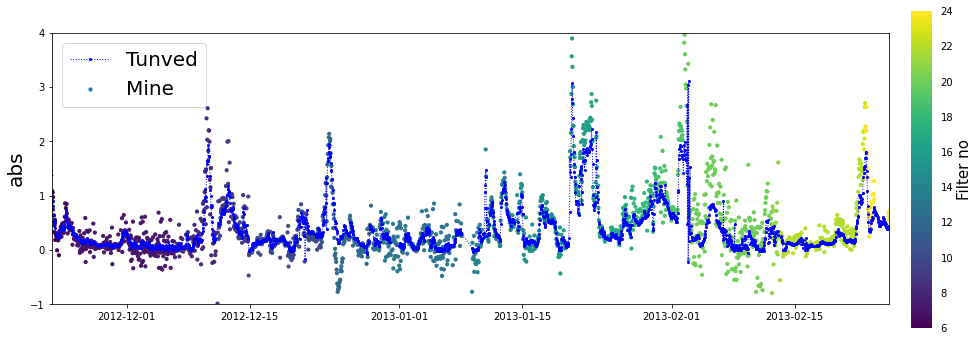

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_peters.index, df_peters['Abs New m-1'], 'o', ms=2, ls=':', lw=1, mec='blue', c='blue', label='Tunved')


filter_num_min = df_abs_neph_clean.filter_num.iloc[df_abs_neph_clean.index.get_loc(df_peters.index[0],method='nearest')]
filter_num_max = df_abs_neph_clean.filter_num.iloc[df_abs_neph_clean.index.get_loc(df_peters.index[-1],method='nearest')]


abs_scatter = ax.scatter(df_abs_neph_clean.index, df_abs_neph_clean.abs_neph, c=df_abs_neph_clean.filter_num, s=10,
                         vmin=filter_num_min, vmax=filter_num_max, label='Mine')
ax.set_ylim(-1,4)
ax.set_xlim(df_peters.index[0],df_peters.index[-1])
ax.set_ylabel('abs',fontsize=20)

cax = fig.add_axes([0.92, 0.06, 0.02, 0.88]) #x,y, width,height
cbar = fig.colorbar(abs_scatter, cax=cax)
cbar.ax.set_ylabel(r'Filter no', fontsize=15)    
cbar.ax.tick_params(axis='y', color='white', left=True, right=True,
                    length=5, width=1.5)
cbar.outline.remove()

ax.legend(fontsize=20)

Lets compare Tunveds to mine

In [47]:
df_comparsion = pd.merge(df_abs_neph, df_peters, how='inner', left_index=True, right_index=True)
df_comparsion['abs_neph'] = df_comparsion['abs_neph']
df_comparsion.loc[df_comparsion['abs_neph'] < 0, ['abs_neph']] = np.nan
df_comparsion.loc[df_comparsion['abs_neph'] > 60, ['abs_neph']] = np.nan
df_comparsion.dropna(subset=['abs_neph'], inplace=True)

In [48]:
def create_regession_plot_volume(df, x_var, y_var, set_max_value, title, savename):
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)] #remove any infs or np.nan
    
    fig, ax = plt.subplots(figsize=(10,10))

    regr = linear_model.LinearRegression(fit_intercept=False)
    max_value = min(df[x_var].max(), df[y_var].max(),set_max_value) #find max value
    x = np.linspace(0, 3.5, 20)

    ax.plot(x, x, linestyle='--')
    ax.scatter(df[x_var], df[y_var], color='none', edgecolors='black')
    ax.set_xlim(0, max_value)
    ax.set_ylim(0, max_value)

    Instrument1 = np.array(df[x_var].values)
    Instrument2 = np.array(df[y_var].values)
    
    Instrument1 = Instrument1.reshape(-1, 1)
    Instrument2 = Instrument2.reshape(-1, 1)

    regr.fit(Instrument1, Instrument2)
    y_pred = regr.predict(Instrument1)

    R2 =  "{:.2f}".format(float(regr.score(Instrument1,Instrument2)))
    intercept = "{:.2f}".format(float(regr.intercept_))
    coef = "{:.2f}".format(float(regr.coef_[0]))    
    cf =  "{:.2f}".format(float(1/(regr.coef_[0])))    

    ax = plt.gca()
    ax.tick_params(bottom=False, top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.plot(x, x, linestyle='--') #y = x line
    smap = ax.scatter(Instrument1, Instrument2, c=df.index, edgecolors='none', cmap = 'Greens')
    ax.plot(Instrument1, y_pred, color='blue', linewidth=3, label='Fitted Line: \n'+str(y_var)+'  = '+str(coef)+str(x_var)+
            '\nR$^{2}$ = '+str(R2)+'\nCF = '+str(cf))

    ax.set_xlabel(str(x_var),fontsize=15)
    ax.set_ylabel(str(y_var),fontsize=15)
    ax.set_title(title+' size: '+str(len(df)))
    
    #colorbar
    N_TICKS = 10
    cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
    indexes = [df.index[i] for i in np.linspace(0,df.shape[0]-1,N_TICKS).astype(int)] 
    cb = fig.colorbar(smap, orientation='vertical',
                  ticks= df.loc[indexes].index.astype(int), cax = cbaxes)
    cb.ax.set_yticklabels([index.strftime('%d %b %Y') for index in indexes])
   
    ax.legend(fontsize=15)    
    ax.set_title(title + ' No. data points: '+str(len(df))+',\n '+str(df.index[0].strftime("%d-%m-%Y")) +' to '+str(df.index[-1].strftime("%d-%m-%Y")))

    plt.savefig(out_path_plots+str(savename)+".jpeg", dpi=200,bbox_inches='tight')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

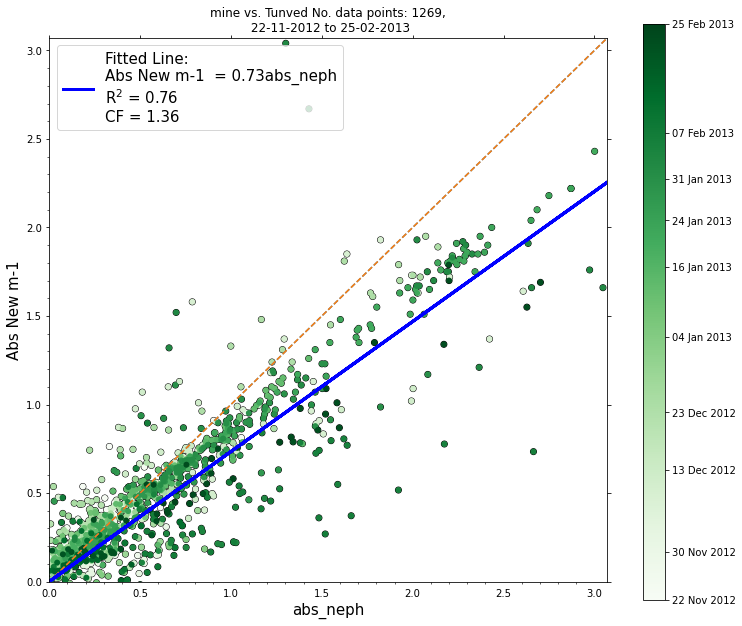

In [49]:
create_regession_plot_volume(df_comparsion, x_var = 'abs_neph',  y_var = 'Abs New m-1', 
                             set_max_value=3.5, title='mine vs. Tunved', savename='mine_tunved_PSAP_date')

## Virkkula

The single-wavelength PSAP presented refereced in Bond et al. (1999) is modified to a 3-wavelength PSAP. The main modifications of this instrument consist of (1) replacing the original green LED with blue, green, and red LEDs; (2) replacing the light source block; (3) replacing the light detectors; and (4) adding a control circuit that switches the LEDs on and off in a cycle. 

The detector wavelengths were determined to be 467 nm, 530 nm, and 660 nm, respectively (Virkkula et al. 2005).

The wavelength of the unmodified PSAP was determined to be 574 nm.

The purpose of the reference detector is to account for variations in light intensity, and the calculation of filter transmission is based on the decrease of the signal-to-reference detector ratio over time. Transmission depends on wavelength, and it has to be calculated separately for each wavelength.

\begin{equation}
\operatorname{Tr}=\frac{\left(\sum \mathrm{SIG} / \sum \mathrm{REF}\right)}{\left(\sum \mathrm{SIG} / \sum \mathrm{REF}\right)_{\mathrm{t}=0}}
\end{equation}

where $\sum \mathrm{SIG}$ and $\sum \mathrm{REF}$ are the sums of Signal and Reference detector outputs during the summing period, and time t = 0 is the time of changing the filter. $\Sigma \mathrm{SIG}_{t=0}$ and $\Sigma \mathrm{REF}_{t=0}$ are
the sums of the signal and reference detector output after the summing period that started at t = 0, and $\Sigma \mathrm{SIG}_{t}$ and $\Sigma \mathrm{REF}_{t}$ are the sums of the signal and reference detector outputs after the summing period that started at time t.

(is there a typo in Virkkula i.e. no t)

The program calculates the absorption coefficient from:

\begin{equation}
\sigma_{\mathrm{PSAP}}=\mathrm{f}(\operatorname{Tr}) \frac{\mathrm{A}}{\mathrm{Q} \Delta \mathrm{t}} \ln \left(\frac{\left(\sum \mathrm{SIG} / \sum \mathrm{REF}\right)_{\mathrm{t}-\Delta \mathrm{t}}}{\left(\sum \mathrm{SIG} / \sum \mathrm{REF}\right)_{\mathrm{t}}}\right)=\mathrm{f}(\mathrm{Tr}) \sigma_{0}
\end{equation}

The transmission correction function in the firmware of the unmodified PSAP (Bond et al. 1999) is:

\begin{equation}
\mathrm{f}(\mathrm{Tr})=\frac{1}{1.0796 \cdot \mathrm{Tr}+0.71}
\end{equation}

f(Tr) presented in Equation (5) should further be multiplied by a spot size correction factor and divided by a calibration constant.

A filter-based absorption measurement can be made by drawing air through a filter and measuring the decrease of light transmission through the sampling area (e.g., Lin et al. 1973). In principle the absorption coefficient for such a method can be derived (e.g., Weingartner et al. 2003) from the Beer-Lambert law as:

\begin{equation}
\sigma_{ap} = \frac{A}{V}*ln(\frac{I_{t-\Delta t}}{I_{t}}),
\end{equation}

where A is the area of the sample spot, $V$ is the volume of air drawn through the spot area during a given time period $\Delta t$,
and $I(t-\Delta t)$ and It are the filter transmittances before and after the time period. This is the principle of both the aethalometer and the PSAP. However, Equation (1) does not give the absorption coefficient directly because of various inherent error sources. Both scattering and absorbing particles collected on the filter alter the internal reflection of the filter in a way that increases the absorption of the aerosol/filter combination (Clarke 1982; Clarke et al. 1987; Petzold et al. 1997; Horvath 1997; Bond et al. 1999). There are several methods for handling these effects see references by Bond et al. (1999) and Weingartner et al. (2003).

PSAP technique measures the particle absorption coefficient ($\sigma_{ap}$) as a function of the decrease in transmittance, Tr, over time as particles accumulate on the filter; that is: 

\begin{equation}
\sigma_{ap} \propto \frac{Tr_{t-\Delta t} - Tr_{t}}{\Delta t}
\end{equation}

where $ Tr_{t}$ is the sample transmittance for the current averaging period and $Tr_{t-\Delta t}$ is the sample
transmittance for the previous averaging period, $\Delta t$. 

\begin{equation}
Tr = \frac{(\sum SIG/\sum REF)}{(\sum SIG/\sum REF)_{t=0}} (2)
\end{equation}

The denominator of Eq. 2 normalizes the transmittance to the value of a new filter. In operation, the filter is changed when Tr < 0.7 (Bond et al. 1999). Furthermore, the change in Tr over ∆t is << 1 and therefore the simplification of:
\begin{equation}
ln\frac{Tr_{t+\Delta t}}{Tr_{t}} = Tr_{t+\Delta t} - Tr_{t} 
\end{equation}
was used to derive Eq. 1 from Beer’s law. 

The instrument references the transmission (i.e., $\tau{_j}$ ≡ $I_{j}$/$I_{j−1}$ ≤ 1 where j is the index corresponding to the time interval $\Delta$tj) to 1.0 (to remove the filter contribution) and decreases with time as the particle loading increases.

The value actually reported by the PSAP includes an empirical calibration that accounts for both of these effects:

\begin{equation}
\sigma_{PSAP} = \frac{\sigma_{ap}}{2(0.5398 \tau + 0.355)}, 
\end{equation}

where $\tau$ is the filter transmission ($\tau$ = 1 for an unloaded filter; this value is reset by the user after installation of each new filter).

In [50]:
df_averaging_times_virkkula = []
datasets = []
for i, df in enumerate(dfs):
    summing_period = 60
    filter_length = len(df)
    
    if filter_length > summing_period: #filter must be larger than time step
    
        df = df.copy()
        df = df.resample('min').mean() #the values should be every minute
        idx = pd.date_range(min(df.index), max(df.index), freq='60s') #create 
        df = df.reindex(idx, fill_value=np.nan) #fill dataframe will missing values
        df = df.rolling(window=3,min_periods=3,center=True).mean() #apply a rolling mean

        times = df.index.to_numpy()
        Is = df.I.to_numpy()
        Ios = df.Io.to_numpy()
        Qs = df.qobs.to_numpy()
        times = times[:-summing_period] 
        filter_num = np.ones(len(times))*int(i+1)
        
        summation_signal = np.convolve(Is[:-summing_period],np.ones(summing_period,dtype=int),'same')
        summation_ref = np.convolve(Ios[:-summing_period],np.ones(summing_period,dtype=int),'same')
        normalise_summation_signal = np.convolve(Is[summing_period:],np.ones(summing_period,dtype=int),'same')
        normalise_summation_ref = np.convolve(Ios[summing_period:],np.ones(summing_period,dtype=int),'same')

        Sig_ref = (summation_signal/summation_ref)/(normalise_summation_signal/normalise_summation_ref)
        ln_Sig_ref = np.log(Sig_ref) #take natural logs        
        Sig_ref_approx = (summation_signal/summation_ref) - (normalise_summation_signal/normalise_summation_ref)        
        Q = np.convolve(Qs, np.ones(summing_period)/summing_period, mode='same')/1000
        
        volume = Q*summing_period
        volume = volume[:-summing_period]

        absorption_approx = ((Area/volume)*(Sig_ref_approx))
        absorption_ln = ((Area/volume)*(ln_Sig_ref))

        absorption_approx_abjusted = absorption_approx*Filter_constant
        absorption_ln_abjusted = absorption_ln*Filter_constant
        
        Tr = (summation_signal/summation_ref)/((df.I.sum())/(df.Io.sum()))
        
        lnTr = np.log(Tr)
          
        dataset = pd.DataFrame({'Datetime': times, 'filter_num':filter_num, 'volume': volume, 
                                'ln_Sig_ref': ln_Sig_ref, 'abs_ln': absorption_ln_abjusted, 
                                'absorption_approx': absorption_approx_abjusted, 'Tr':Tr, 'lnTr':lnTr})
        datasets.append(dataset)
    else:
        pass

df_averaging_times_virkkula = pd.concat(datasets)
df_averaging_times_virkkula.set_index('Datetime', inplace=True)

In [51]:
df_averaging_times_virkkula.dropna(how='all',subset=['volume','ln_Sig_ref','abs_ln','absorption_approx','lnTr','Tr'], inplace=True)
remove_datetimes_slice(df_averaging_times_virkkula, dt_min = '2013-10-29 00:00:01', dt_max='2013-11-19 08:46:49')
df_averaging_times_virkkula.head()

,filter_num,volume,ln_Sig_ref,abs_ln,absorption_approx,Tr,lnTr
Datetime,,,,,,,
2012-11-18 11:29:00,1.0,0.030474,-0.005006,-0.000003,-0.000002,0.999278,-0.000723
2012-11-18 11:30:00,1.0,0.030971,-0.004859,-0.000003,-0.000002,0.999378,-0.000622
2012-11-18 11:31:00,1.0,0.031472,-0.004709,-0.000002,-0.000002,0.999480,-0.000521
2012-11-18 11:32:00,1.0,0.031973,-0.004560,-0.000002,-0.000002,0.999581,-0.000419
2012-11-18 11:33:00,1.0,0.032473,-0.004411,-0.000002,-0.000002,0.999681,-0.000319


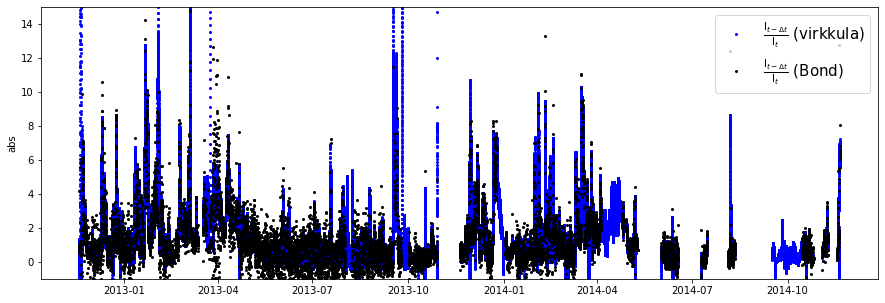

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_averaging_times_virkkula.index, df_averaging_times_virkkula.abs_ln*10**6, 'o', ms=2, mec='blue', 
        c='blue', label = r'$\frac{\mathrm{I}_{t-\Delta t}}{\mathrm{I}_{t}}$ (virkkula)')
ax.plot(df_abs_neph_clean.index, df_abs_neph_clean.abs_ln*10**6, 'o', ms=2, mec='black', c='black', 
        label = r'$\frac{\mathrm{I}_{t-\Delta t}}{\mathrm{I}_{t}}$ (Bond)')
ax.set_ylim(-1,15)
ax.set_ylabel('abs')
ax.legend(fontsize=15)

## EMPIRICAL TRANSMISSION CORRECTION FUNCTION

\begin{equation}
\sigma_{\mathrm{AP}}(\mathrm{PSAP})=\left(\mathrm{k}_{0}+\mathrm{k}_{1} \mathrm{~h}\left(\omega_{0}\right) \ln (\mathrm{Tr})\right) \sigma_{0}-\mathrm{s} \sigma_{\mathrm{SP}},
\end{equation}

$\omega_{0}$ is the single-scattering albedo

In [53]:
k0 = 0.306
k1 = -0.522
h0 = 1.234
h1 = -0.952
s = 0.016

In [54]:
def remove_neph_virkkula(df, abs_var):
    df['abs_neph'] = (df[abs_var]*10**6)*(1/(df['Tr']*1.0796 + 0.71))    
    df['abs_neph_virkkula'] = (k0 + k1*df['lnTr'])*(df['abs_neph']) - s*df['scat550']
    return df   

In [55]:
df_abs_hourly_virkkula = df_averaging_times_virkkula.resample('60T').mean() #resample hourly 
df_abs_neph_virkkula = pd.merge(df_abs_hourly_virkkula, optical_data, how='inner', left_index=True, right_index=True) #merge the two dataframes
df_abs_neph_virkkula = remove_neph_virkkula(df_abs_neph_virkkula, abs_var='abs_ln') #remove scattering from PSAP values

In [56]:
df_abs_hourly_virkkula_clean = remove_extreme_values(df_abs_neph_virkkula, var='abs_neph_virkkula')

Mean :0.1574004647298394


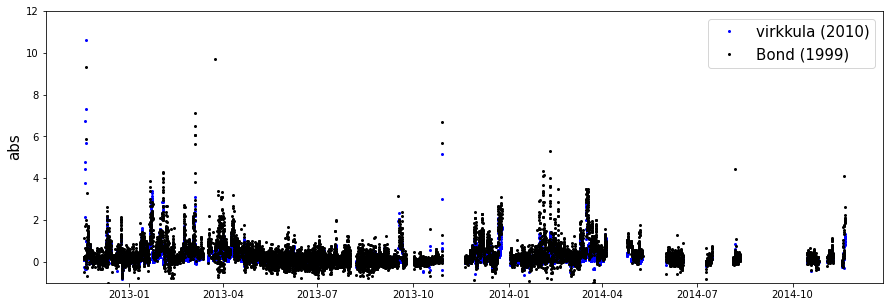

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_abs_hourly_virkkula_clean.index, df_abs_hourly_virkkula_clean.abs_neph_virkkula, 'o', ms=2, 
        mec='blue', c='blue',label='virkkula (2010)')
ax.plot(df_abs_neph_clean.index, df_abs_neph_clean.abs_neph, 'o', ms=2, mec='black', c='black',
      label='Bond (1999)')
ax.set_ylim(-1,12)
ax.set_ylabel('abs',fontsize=15)
ax.legend(fontsize=15,loc=1)

In [58]:
df_abs_hourly_virkkula_clean = df_abs_hourly_virkkula_clean[['abs_neph_virkkula']]
df_abs_neph_clean = df_abs_neph_clean[['abs_neph']]

In [59]:
df_comparsion_virkkula_bond = pd.merge(df_abs_hourly_virkkula_clean, df_abs_neph_clean, how='inner', left_index=True, right_index=True)
df_comparsion_virkkula_bond.loc[df_comparsion_virkkula_bond['abs_neph'] < 0, ['abs_neph']] = np.nan
df_comparsion_virkkula_bond.loc[df_comparsion_virkkula_bond['abs_neph'] > 60, ['abs_neph']] = np.nan
df_comparsion_virkkula_bond.loc[df_comparsion_virkkula_bond['abs_neph_virkkula'] < 0, ['abs_neph_virkkula']] = np.nan
df_comparsion_virkkula_bond.loc[df_comparsion_virkkula_bond['abs_neph_virkkula'] > 60, ['abs_neph_virkkula']] = np.nan
df_comparsion_virkkula_bond.dropna(subset=['abs_neph','abs_neph_virkkula'], inplace=True)

<module 'matplotlib.pyplot' from 'C:\\Users\\DominicHeslinRees\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

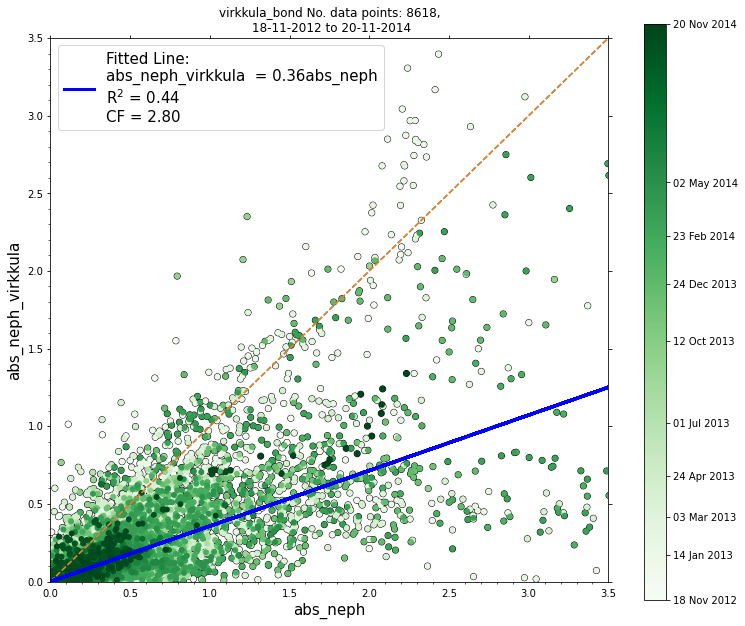

In [60]:
create_regession_plot_volume(df_comparsion_virkkula_bond, x_var = 'abs_neph',  y_var = 'abs_neph_virkkula', 
                             set_max_value=3.5, title='virkkula_bond', savename='virkkula_bond')

Bond vs. Virkkula (2010)

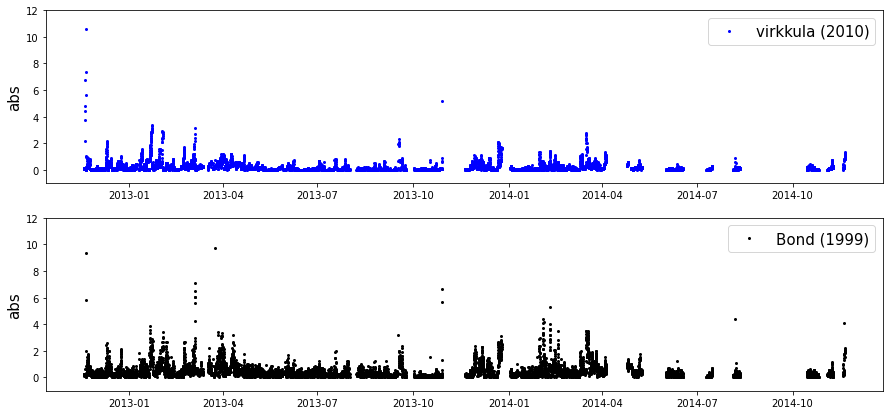

In [61]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,7))
ax1.plot(df_comparsion_virkkula_bond.index, df_comparsion_virkkula_bond.abs_neph_virkkula, 'o', ms=2, 
        mec='blue', c='blue',label='virkkula (2010)')
ax2.plot(df_comparsion_virkkula_bond.index, df_comparsion_virkkula_bond.abs_neph, 'o', ms=2, mec='black', c='black',
      label='Bond (1999)')
ax1.set_ylim(-1,12)
ax1.set_ylabel('abs',fontsize=15)
ax1.legend(fontsize=15,loc=1)

ax2.set_ylim(-1,12)
ax2.set_ylabel('abs',fontsize=15)
ax2.legend(fontsize=15,loc=1)

In [62]:
df_abs_hourly_virkkula_clean.to_csv(out_path_datafiles+'df_abs_neph_clean_virkkula.dat', index=True)